In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import os
import matplotlib.pyplot as plt

# @title REALDSIP Data Preprocessing and Extraction

In [ ]:
!wget https://archive.ics.uci.edu/static/public/305/realdisp+activity+recognition+dataset.zip  -O dataset.zip

--2024-11-25 06:27:18--  https://archive.ics.uci.edu/static/public/305/realdisp+activity+recognition+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘dataset.zip’

dataset.zip             [                <=> ]   2.49G  27.8MB/s    in 99s     

2024-11-25 06:28:57 (25.7 MB/s) - ‘dataset.zip’ saved [2671716334]



In [ ]:
import zipfile
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')


In [ ]:
# Set path to the dataset folder
dataset_path = './dataset'

Now we define specify columns for accelerometer data and activity labels in the REALDISP dataset.

The load_realdisp_data function loads .log files using pandas, extracting sensor data (left lower arm accelerometer) and corresponding activity labels.

The prepare_data_for_model function processes multiple files (ideal and self-placement), stacking the extracted data into arrays for model input.

Finally, the create_windows function generates sliding windows of data with overlap, preparing features and labels for time-series modeling.

These steps ensure proper preprocessing and formatting of data for downstream tasks like training or evaluation.

In [ ]:
# @title REALDSIP Data Preprocessing and Extraction
# Define columns of interest based on the manual
LLA_ACC_X = 55
LLA_ACC_Y = 56
LLA_ACC_Z = 57
ACTIVITY_LABEL = -1  # Last column is activity label

def resample_data(data, labels, original_freq=50, target_freq=30):
    """
    Resample the data from the original frequency to the target frequency.

    Args:
        data (ndarray): Sensor data with shape (n_samples, n_features).
        labels (ndarray): Corresponding labels with shape (n_samples,).
        original_freq (int): Original sampling frequency of the data.
        target_freq (int): Target sampling frequency.

    Returns:
        resampled_data (ndarray): Resampled sensor data.
        resampled_labels (ndarray): Resampled labels.
    """
    factor = original_freq / target_freq
    if not factor.is_integer():
        raise ValueError("Original frequency must be a multiple of the target frequency.")

    factor = int(factor)
    resampled_data = data[::factor]
    resampled_labels = labels[::factor]
    return resampled_data, resampled_labels

def load_realdisp_data(file_path, sensor_columns, resample=False, target_freq=30):
    """
    Load data from a REALDISP .log file and extract relevant sensor columns and activity labels.

    Args:
        file_path (str): Path to the log file.
        sensor_columns (list): Columns to extract for sensor data.
        resample (bool): Whether to resample the data to a lower frequency.
        target_freq (int): Target frequency for resampling.

    Returns:
        lla_data (ndarray): Sensor data.
        labels (ndarray): Corresponding activity labels.
    """
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    lla_data = df.iloc[:, sensor_columns].values
    labels = df.iloc[:, ACTIVITY_LABEL].values

    if resample:
        lla_data, labels = resample_data(lla_data, labels, original_freq=50, target_freq=target_freq)

    return lla_data, labels

def prepare_data_for_model(ideal_files, self_files, resample=False, target_freq=30):
    """
    Load and prepare the dataset for HaRNet5 from both ideal and self-placement files.

    Args:
        ideal_files (list): List of ideal placement files.
        self_files (list): List of self-placement files.
        resample (bool): Whether to resample the data to a lower frequency.
        target_freq (int): Target frequency for resampling.

    Returns:
        X_ideal, y_ideal, X_self, y_self: Processed data and labels.
    """
    X_ideal, y_ideal = [], []
    X_self, y_self = [], []

    for file in ideal_files:
        lla_data, labels = load_realdisp_data(
            os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z],
            resample=resample, target_freq=target_freq
        )
        X_ideal.append(lla_data)
        y_ideal.append(labels)

    for file in self_files:
        lla_data, labels = load_realdisp_data(
            os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z],
            resample=resample, target_freq=target_freq
        )
        X_self.append(lla_data)
        y_self.append(labels)

    X_ideal = np.vstack(X_ideal)
    y_ideal = np.hstack(y_ideal)
    X_self = np.vstack(X_self)
    y_self = np.hstack(y_self)

    return X_ideal, y_ideal, X_self, y_self

def create_windows(X, y, window_size=300, overlap=0.5):
    """Create sliding windows from the data with overlap."""
    step = int(window_size * (1 - overlap))
    features = []
    labels = []

    for i in range(0, len(X) - window_size, step):
        window = X[i:i + window_size].T  # Shape as (channels, sequence_length)
        label = y[i + window_size // 2]  # Take the middle label
        features.append(window)
        labels.append(label)

    return np.array(features), np.array(labels)


Now we implement a leave-one-participant-out (LOPO) cross-validation approach, where participant 17 is excluded from the training set and used exclusively for testing.

In [ ]:
# Define the participant to leave out
participant_id = '17'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

print("Training Ideal Files:", len(ideal_files))
print("Training Self Files:", len(self_files))
print("Testing Ideal Files (Participant 17):", len(ideal_test_files))
print("Testing Self Files (Participant 17):", len(self_test_files))

Training Ideal Files: 16
Training Self Files: 16
Testing Ideal Files (Participant 17): 1
Testing Self Files (Participant 17): 1


In [ ]:
# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)


<ipython-input-6-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-6-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-6-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-6-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-6-8c5a7cd72b6

The dataset is first split into training and testing files based on the participant ID. The training data is standardized using StandardScaler, and the same scaler is applied to the testing data to ensure consistency.

In [ ]:
# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

In [ ]:
# Load and preprocess test data (Participant 17)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)


<ipython-input-6-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-6-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


In [ ]:
# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)


Sliding windows are created from both training and testing data to capture temporal sequences, with features and labels prepared for time-series analysis. These sliding windows are then converted to PyTorch tensors for model training and evaluation. Additionally, the ideal training data is further split into training and validation sets for monitoring model performance during training. This structure ensures that the model is evaluated on unseen data from participant 17, aligning with the LOPO validation strategy.

In [ ]:
# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)


In [ ]:
# Create sliding windows for testing data (Participant 17)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)


In [ ]:
# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

In [ ]:
# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)


DataLoader Creation:

Combines datasets using TensorDataset and creates DataLoader for training (shuffled) and validation (ordered) with a batch size of 16.
Debugging Information:



In [ ]:
# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Display shape information for debugging
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_ideal_tensor_test shape: {X_ideal_tensor_test.shape}, y_ideal_tensor_test shape: {y_ideal_tensor_test.shape}")


X_train shape: torch.Size([13242, 3, 300]), y_train shape: torch.Size([13242])
X_val shape: torch.Size([3311, 3, 300]), y_val shape: torch.Size([3311])
X_ideal_tensor_test shape: torch.Size([648, 3, 300]), y_ideal_tensor_test shape: torch.Size([648])


Pretrained Model Loading and Classifier adjustment:

We now load the pretrained HaRNet10 model from torch.hub, designed for human activity recognition (HAR) and replace the model's output layer to match the number of unique activity classes in the dataset for fine-tuning.

In [ ]:
import torch.nn as nn

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))  # Calculate the number of unique classes
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)



/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct mal

131 Weights loaded


Loss Function and Optimizer:

Uses CrossEntropyLoss for multi-class classification and Adam optimizer with a learning rate of 1e-4 for efficient training.

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Now, the training loop will updates the model’s weights based on the training data.
The validation loop calculates loss and accuracy without updating weights, providing a snapshot of the model’s generalization to unseen data.

In [ ]:
# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Set the number of epochs for training
num_epochs = 2

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()               # Clear gradients
        outputs = model(batch_X)            # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights
        running_loss += loss.item()         # Accumulate loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)            # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            val_loss += loss.item()             # Accumulate loss
            _, predicted = torch.max(outputs, 1)  # Get predicted labels
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy /= len(val_dataset)

    # Store results for plotting
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/2, Loss: 420.7663, Val Loss: 46.4920, Val Accuracy: 0.9326
Epoch 2/2, Loss: 186.7915, Val Loss: 39.4915, Val Accuracy: 0.9420


In [ ]:
from sklearn.metrics import f1_score

# Evaluate on the Ideal Placement Test Data for Participant 17
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 17 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 17
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 17 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')


Participant 17 Ideal Placement Accuracy: 0.8796, F1 Score: 0.8617
Participant 17 Self-Placement Accuracy: 0.9552, F1 Score: 0.9603


Participant Wise analysis starts below (Ideal train - Ideal test / Self test)  

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import os
import matplotlib.pyplot as plt

# @title REALDSIP Data Preprocessing and Extraction

#!wget https://archive.ics.uci.edu/static/public/305/realdisp+activity+recognition+dataset.zip  -O dataset.zip

'''
import zipfile
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')
# Set path to the dataset folder
dataset_path = './dataset'
'''
# Define columns of interest based on the manual
LLA_ACC_X = 55
LLA_ACC_Y = 56
LLA_ACC_Z = 57
ACTIVITY_LABEL = -1  # Last column is activity label

def resample_data(data, labels, original_freq=50, target_freq=30):
    """
    Resample the data from the original frequency to the target frequency.

    Args:
        data (ndarray): Sensor data with shape (n_samples, n_features).
        labels (ndarray): Corresponding labels with shape (n_samples,).
        original_freq (int): Original sampling frequency of the data.
        target_freq (int): Target sampling frequency.

    Returns:
        resampled_data (ndarray): Resampled sensor data.
        resampled_labels (ndarray): Resampled labels.
    """
    factor = original_freq / target_freq
    if not factor.is_integer():
        raise ValueError("Original frequency must be a multiple of the target frequency.")

    factor = int(factor)
    resampled_data = data[::factor]
    resampled_labels = labels[::factor]
    return resampled_data, resampled_labels

def load_realdisp_data(file_path, sensor_columns, resample=False, target_freq=30):
    """
    Load data from a REALDISP .log file and extract relevant sensor columns and activity labels.

    Args:
        file_path (str): Path to the log file.
        sensor_columns (list): Columns to extract for sensor data.
        resample (bool): Whether to resample the data to a lower frequency.
        target_freq (int): Target frequency for resampling.

    Returns:
        lla_data (ndarray): Sensor data.
        labels (ndarray): Corresponding activity labels.
    """
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    lla_data = df.iloc[:, sensor_columns].values
    labels = df.iloc[:, ACTIVITY_LABEL].values

    if resample:
        lla_data, labels = resample_data(lla_data, labels, original_freq=50, target_freq=target_freq)

    return lla_data, labels

def prepare_data_for_model(ideal_files, self_files, resample=False, target_freq=30):
    """
    Load and prepare the dataset for HaRNet5 from both ideal and self-placement files.

    Args:
        ideal_files (list): List of ideal placement files.
        self_files (list): List of self-placement files.
        resample (bool): Whether to resample the data to a lower frequency.
        target_freq (int): Target frequency for resampling.

    Returns:
        X_ideal, y_ideal, X_self, y_self: Processed data and labels.
    """
    X_ideal, y_ideal = [], []
    X_self, y_self = [], []

    for file in ideal_files:
        lla_data, labels = load_realdisp_data(
            os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z],
            resample=resample, target_freq=target_freq
        )
        X_ideal.append(lla_data)
        y_ideal.append(labels)

    for file in self_files:
        lla_data, labels = load_realdisp_data(
            os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z],
            resample=resample, target_freq=target_freq
        )
        X_self.append(lla_data)
        y_self.append(labels)

    X_ideal = np.vstack(X_ideal)
    y_ideal = np.hstack(y_ideal)
    X_self = np.vstack(X_self)
    y_self = np.hstack(y_self)

    return X_ideal, y_ideal, X_self, y_self

def create_windows(X, y, window_size=300, overlap=0.5):
    """Create sliding windows from the data with overlap."""
    step = int(window_size * (1 - overlap))
    features = []
    labels = []

    for i in range(0, len(X) - window_size, step):
        window = X[i:i + window_size].T  # Shape as (channels, sequence_length)
        label = y[i + window_size // 2]  # Take the middle label
        features.append(window)
        labels.append(label)

    return np.array(features), np.array(labels)



<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 560.3500, Val Loss: 47.0359, Val Accuracy: 0.9272
Participant 17 Ideal Placement Accuracy: 0.8472, F1 Score: 0.8328
Participant 17 Self-Placement Accuracy: 0.9561, F1 Score: 0.9541


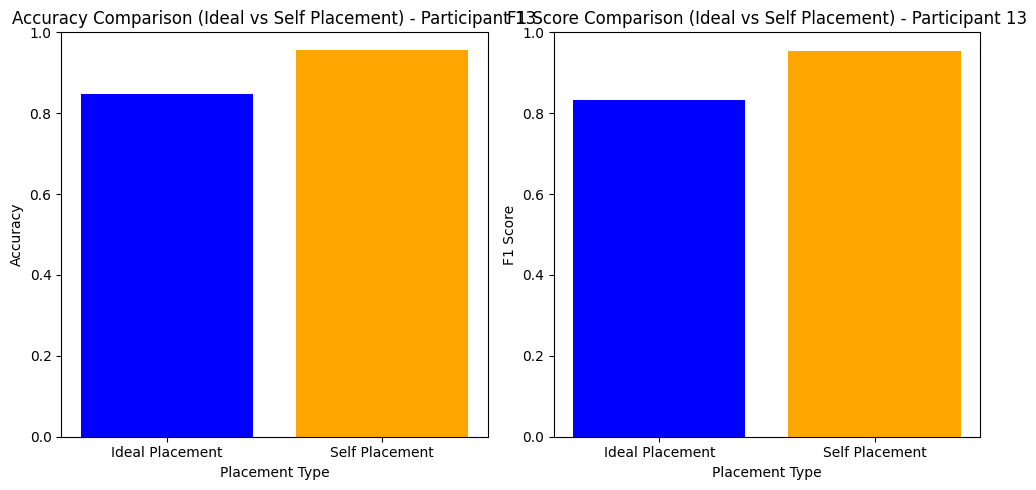

In [ ]:
#@title Participant left out = 17
# Define the participant to leave out
participant_id = '17'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 17 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 17 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 13')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 13')

plt.tight_layout()
plt.show()


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 543.4868, Val Loss: 56.8268, Val Accuracy: 0.9161
Participant 16 Ideal Placement Accuracy: 0.7971, F1 Score: 0.7742
Participant 16 Self-Placement Accuracy: 0.8288, F1 Score: 0.8090


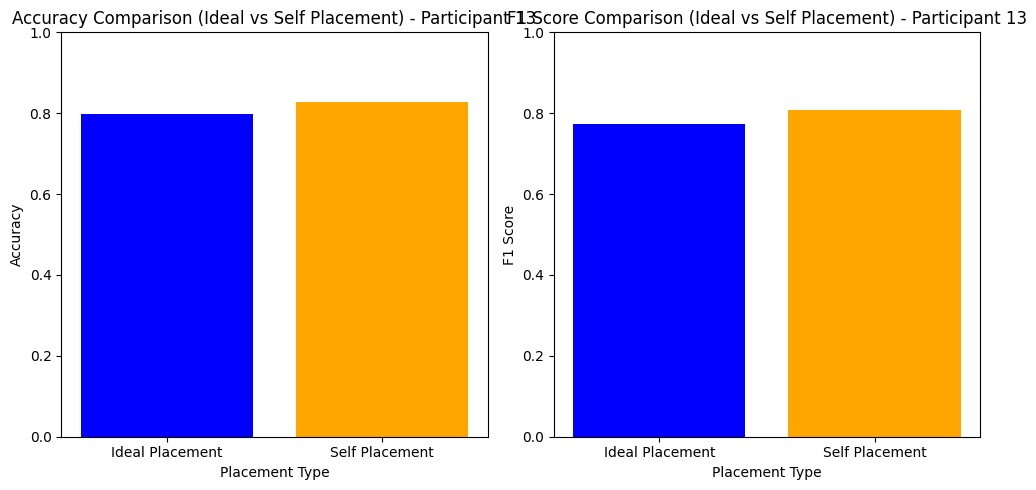

In [ ]:
#@title Participant left out = 16
# Define the participant to leave out
participant_id = '16'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 16 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 16 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 13')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 13')

plt.tight_layout()
plt.show()


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 548.2042, Val Loss: 47.7858, Val Accuracy: 0.9337
Participant 15 Ideal Placement Accuracy: 0.8818, F1 Score: 0.8796
Participant 15 Self-Placement Accuracy: 0.8913, F1 Score: 0.8891


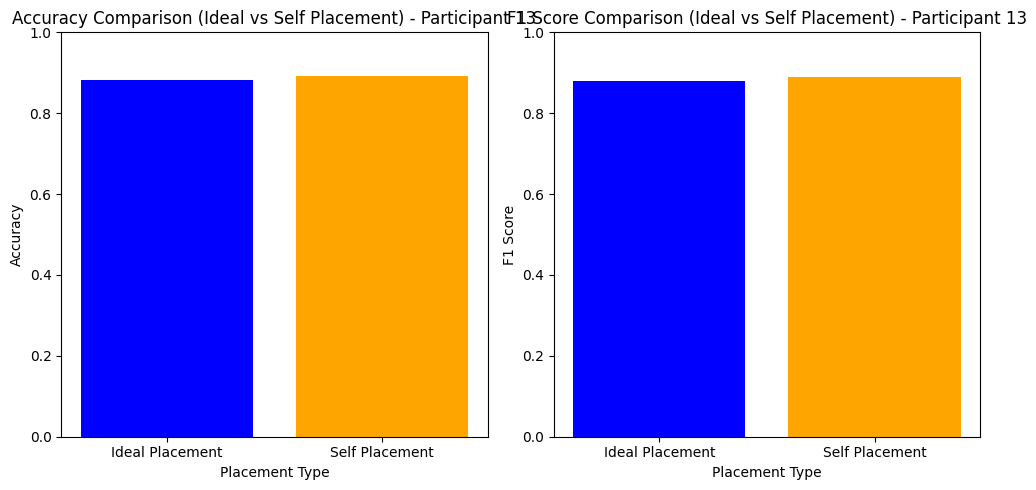

In [ ]:
#@title Participant left out = 15
# Define the participant to leave out
participant_id = '15'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 15 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 15 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 13')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 13')

plt.tight_layout()
plt.show()


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 540.1762, Val Loss: 55.4503, Val Accuracy: 0.9065
Participant 14 Ideal Placement Accuracy: 0.9315, F1 Score: 0.9254
Participant 14 Self-Placement Accuracy: 0.9023, F1 Score: 0.8966


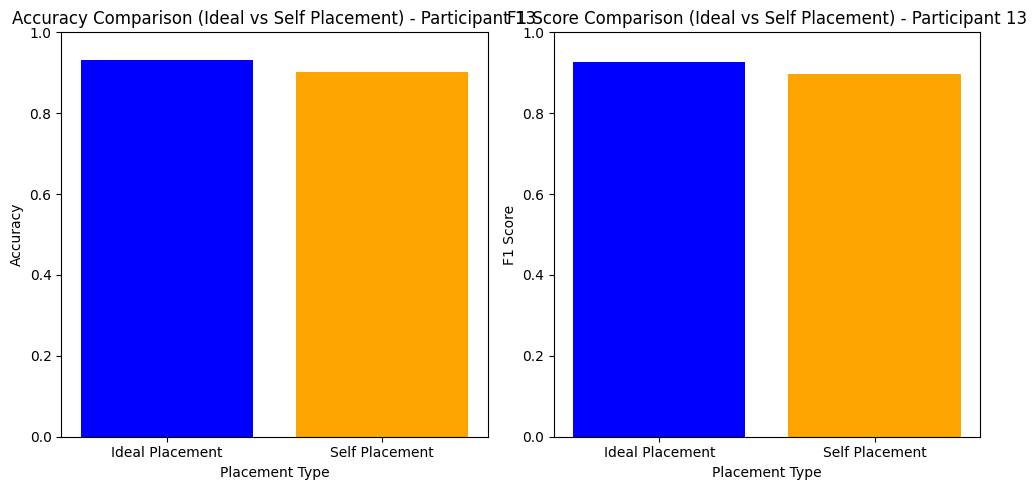

In [ ]:
#@title Participant left out = 14
# Define the participant to leave out
participant_id = '14'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 14 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 14 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 13')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 13')

plt.tight_layout()
plt.show()


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 536.7087, Val Loss: 51.0204, Val Accuracy: 0.9181
Participant 13 Ideal Placement Accuracy: 0.8602, F1 Score: 0.8349
Participant 13 Self-Placement Accuracy: 0.7106, F1 Score: 0.5904


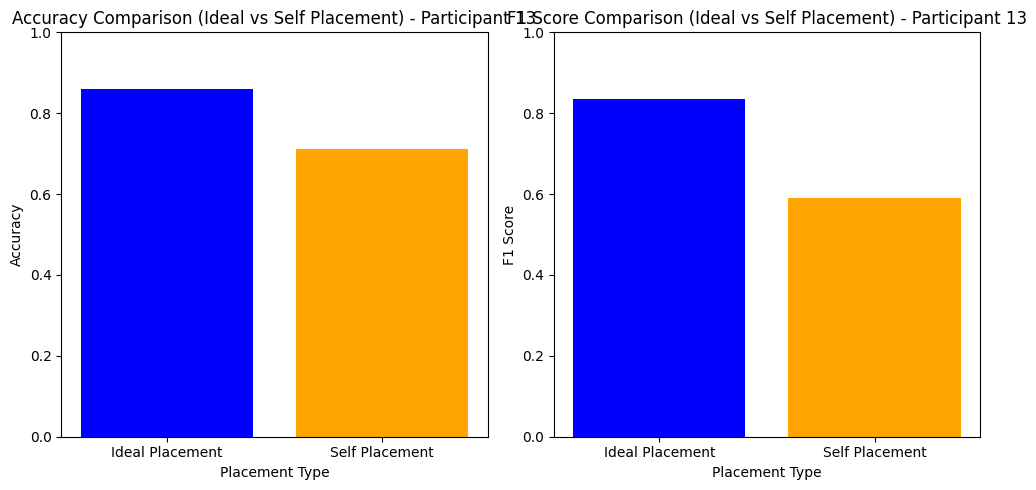

In [ ]:
#@title Participant left out = 13
# Define the participant to leave out
participant_id = '13'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 13 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 13 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 13')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 13')

plt.tight_layout()
plt.show()


<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6

131 Weights loaded
Epoch 1/3, Loss: 521.8051, Val Loss: 50.4457, Val Accuracy: 0.9181
Epoch 2/3, Loss: 185.8557, Val Loss: 33.9378, Val Accuracy: 0.9417
Epoch 3/3, Loss: 120.9752, Val Loss: 31.4239, Val Accuracy: 0.9499
Participant 13 Ideal Placement Accuracy: 0.8910, F1 Score: 0.8802
Participant 13 Self-Placement Accuracy: 0.7106, F1 Score: 0.5904


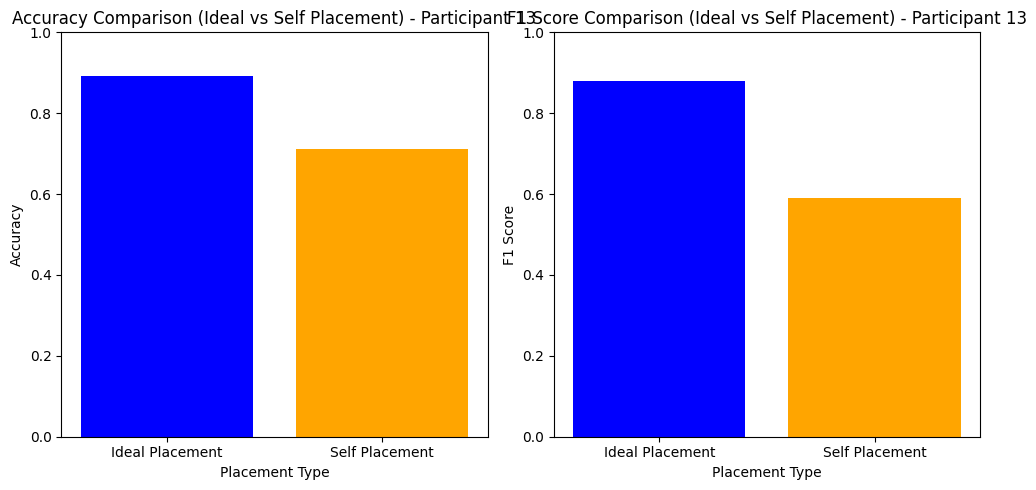

In [ ]:
#@title Participant left out = 13 (multiple(3) epochs) -----> Result= Some improvements in ideal F1 score but Self remained same
# Define the participant to leave out
participant_id = '13'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 13 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 13 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 13')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 13')

plt.tight_layout()
plt.show()


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 532.6314, Val Loss: 50.9585, Val Accuracy: 0.9231
Participant 12 Ideal Placement Accuracy: 0.8495, F1 Score: 0.8406
Participant 12 Self-Placement Accuracy: 0.8619, F1 Score: 0.8395


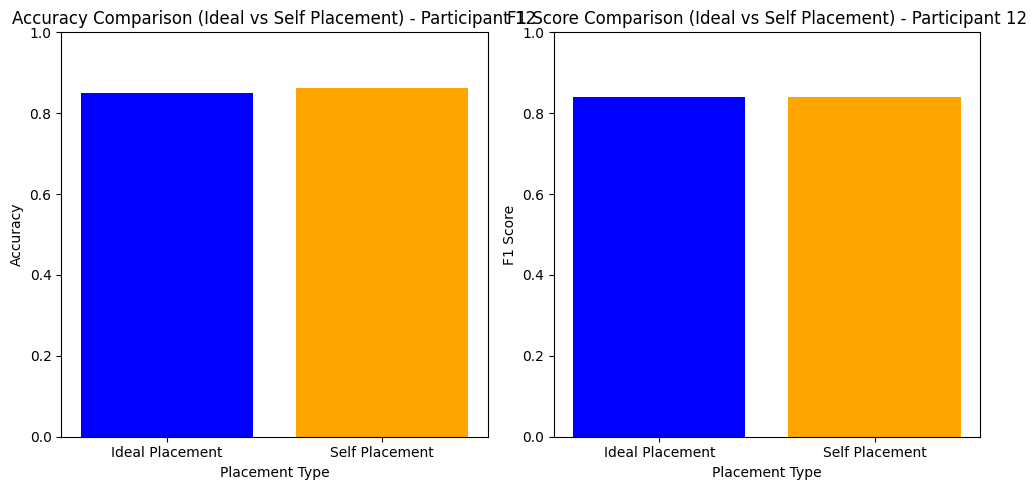

In [ ]:
#@title Participant left out = 12
# Define the participant to leave out
participant_id = '12'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 12 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 12 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 12')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 12')

plt.tight_layout()
plt.show()


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 540.6211, Val Loss: 54.8009, Val Accuracy: 0.9170
Participant 11 Ideal Placement Accuracy: 0.8271, F1 Score: 0.8106
Participant 11 Self-Placement Accuracy: 0.8795, F1 Score: 0.8660


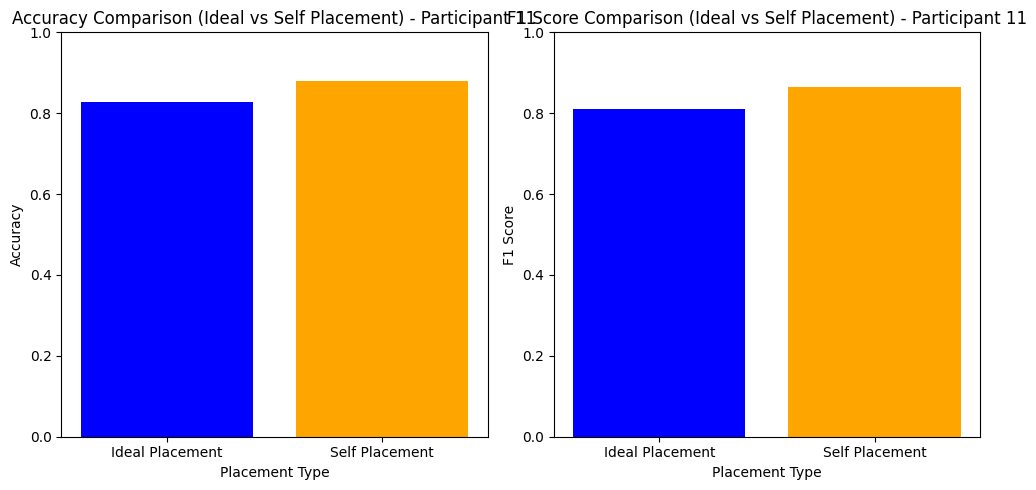

In [ ]:
#@title Participant left out = 11
# Define the participant to leave out
participant_id = '11'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 11 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 11 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 11')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 11')

plt.tight_layout()
plt.show()


<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6

131 Weights loaded
Epoch 1/1, Loss: 543.0912, Val Loss: 56.5812, Val Accuracy: 0.9191
Participant 10 Ideal Placement Accuracy: 0.9474, F1 Score: 0.9399
Participant 10 Self-Placement Accuracy: 0.9070, F1 Score: 0.8964


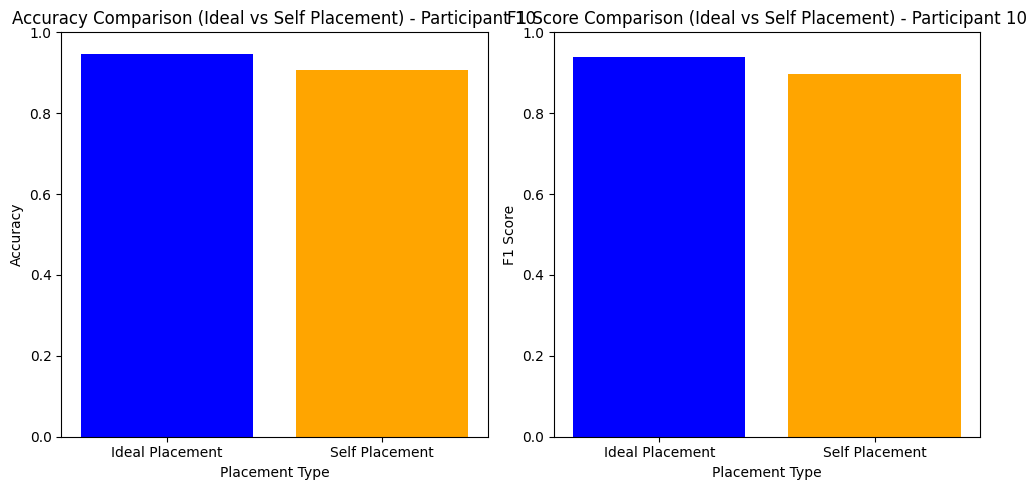

In [ ]:
#@title Participant left out = 10
# Define the participant to leave out
participant_id = '10'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 13
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 10 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 13
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 10 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 10')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 10')

plt.tight_layout()
plt.show()


<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-18-7ec3a6

131 Weights loaded
Epoch 1/1, Loss: 541.3286, Val Loss: 47.9099, Val Accuracy: 0.9217
Participant 11 Ideal Placement Accuracy: 0.9240, F1 Score: 0.9140
Participant 11 Self-Placement Accuracy: 0.8876, F1 Score: 0.8930


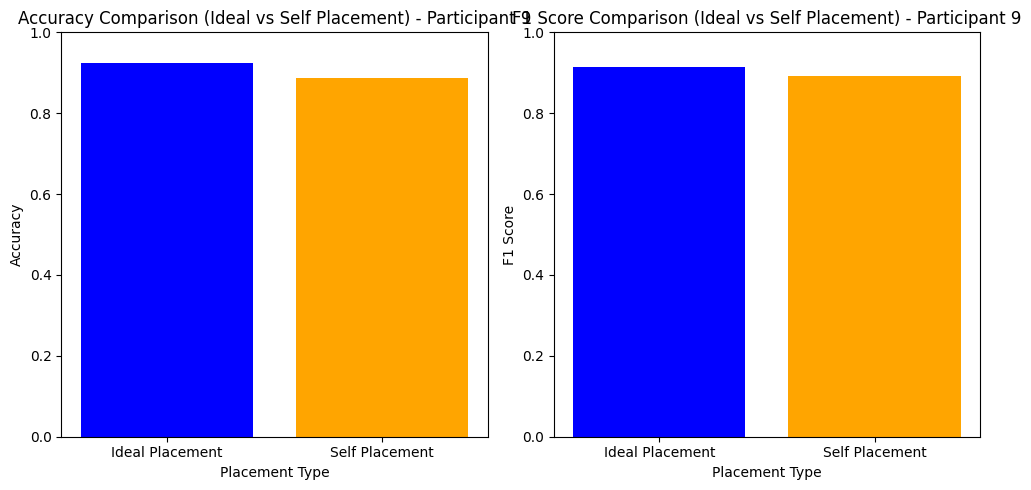

In [ ]:
#@title Participant left out = 9
# Define the participant to leave out
participant_id = '9'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 11 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 11 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 9')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 9')

plt.tight_layout()
plt.show()


<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6

131 Weights loaded
Epoch 1/1, Loss: 538.2661, Val Loss: 49.1220, Val Accuracy: 0.9164
Participant 8 Ideal Placement Accuracy: 0.8963, F1 Score: 0.8898
Participant 8 Self-Placement Accuracy: 0.9249, F1 Score: 0.9200


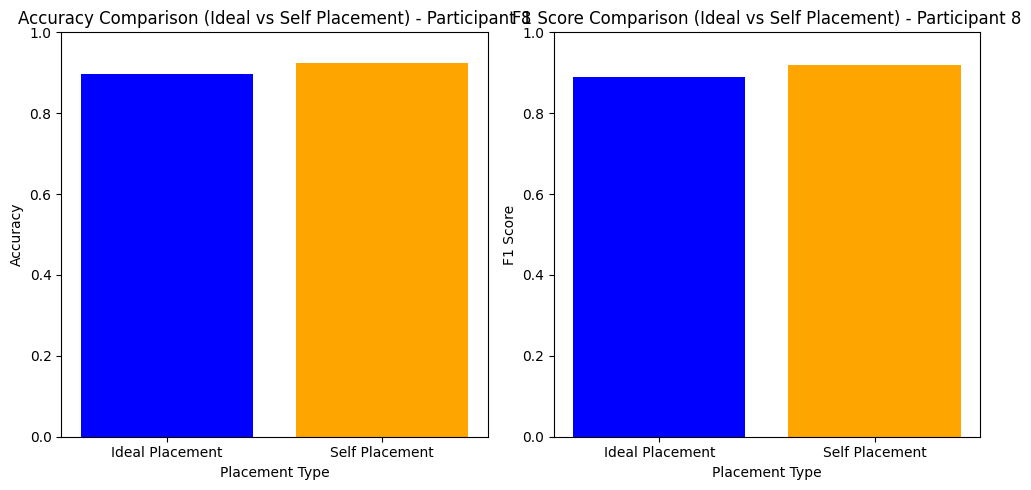

In [ ]:
#@title Participant left out = 8
# Define the participant to leave out
participant_id = '8'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 8 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 8 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 8')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 8')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 7): 16
Training Self Files (Excluding Participant 7): 16
Testing Ideal Files (Participant 7): 1
Testing Self Files (Participant 7): 1


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 551.7216, Val Loss: 46.4971, Val Accuracy: 0.9303
Participant 7 Ideal Placement Accuracy: 0.9588, F1 Score: 0.9575
Participant 7 Self-Placement Accuracy: 0.9160, F1 Score: 0.9116


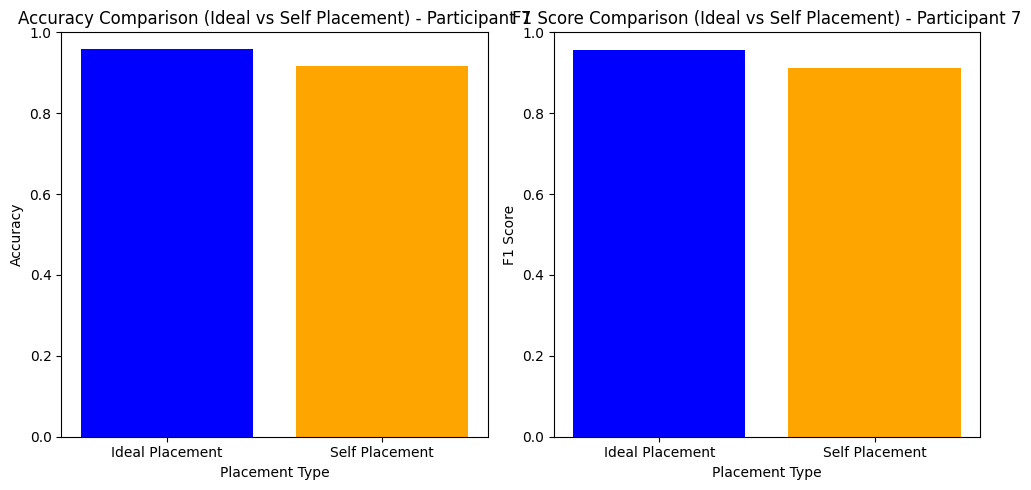

In [ ]:
#@title Participant left out = 7
# Define the participant to leave out
participant_id = '7'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 7 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 7 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 7')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 7')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 6): 16
Training Self Files (Excluding Participant 6): 16
Testing Ideal Files (Participant 6): 1
Testing Self Files (Participant 6): 1
Testing Ideal File Name(s) for Participant 6: ['subject6_ideal.log']
Testing Self File Name(s) for Participant 6: ['subject6_self.log']


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 527.9178, Val Loss: 52.7265, Val Accuracy: 0.9244
Participant 6 Ideal Placement Accuracy: 0.9060, F1 Score: 0.9086
Participant 6 Self-Placement Accuracy: 0.6954, F1 Score: 0.5704


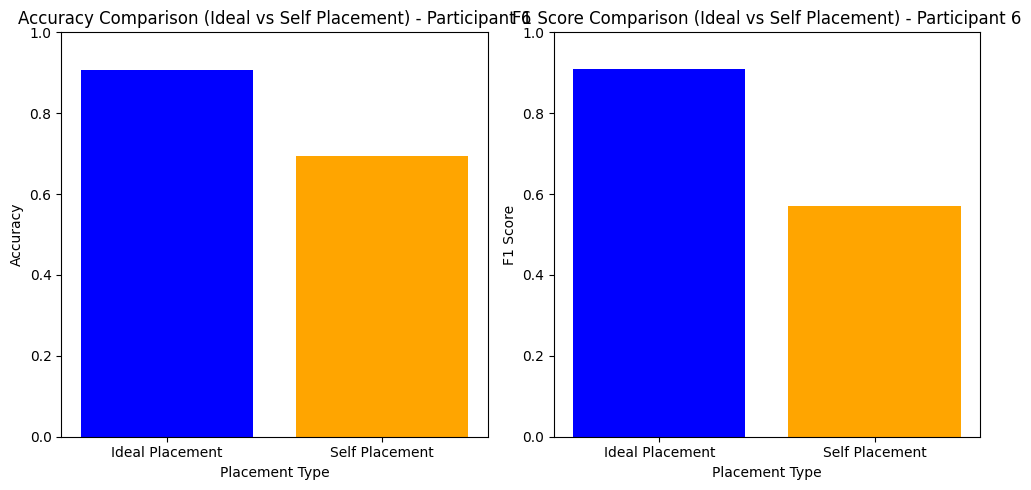

In [ ]:
#@title Participant left out = 6
# Define the participant to leave out
participant_id = '6'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 6 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 6 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 6')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 6')

plt.tight_layout()
plt.show()


<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6684abb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-23-7ec3a6

131 Weights loaded
Epoch 1/1, Loss: 541.0490, Val Loss: 40.1645, Val Accuracy: 0.9311
Participant 5 Ideal Placement Accuracy: 0.8963, F1 Score: 0.8904
Participant 5 Self-Placement Accuracy: 0.8067, F1 Score: 0.8056


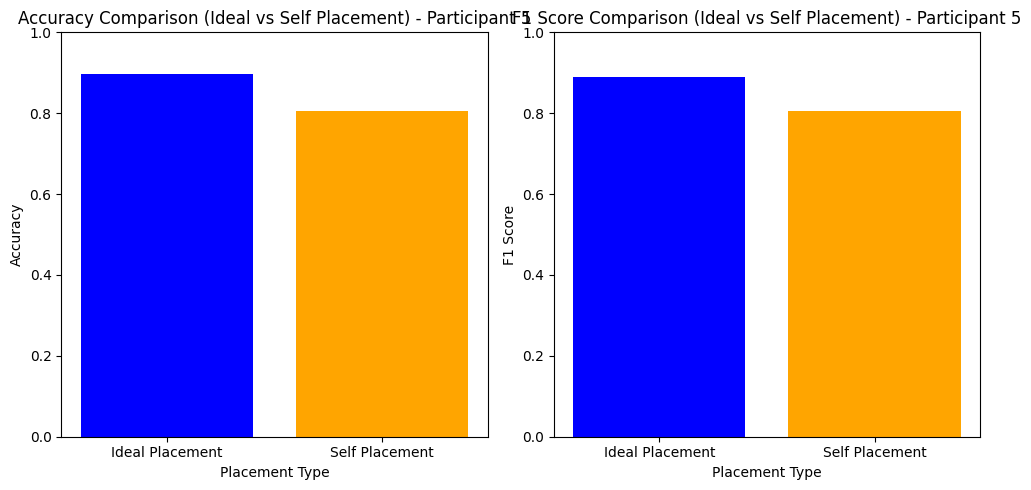

In [ ]:
#@title Participant left out = 5
# Define the participant to leave out
participant_id = '5'

# Separate files for training and testing
ideal_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id not in f]
self_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if '_ideal.log' in f and participant_id in f]
self_test_files = [f for f in os.listdir(dataset_path) if '_self.log' in f and participant_id in f]

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 5 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 5 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 5')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 5')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 5): 16
Training Self Files (Excluding Participant 5): 16
Testing Ideal Files (Participant 5): 1
Testing Self Files (Participant 5): 1
Testing Ideal File Name(s) for Participant 5: ['subject5_ideal.log']
Testing Self File Name(s) for Participant 5: ['subject5_self.log']


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

Shape of X_ideal_train (Excluding Participant 5): (2358569, 3)
Shape of y_ideal_train (Excluding Participant 5): (2358569,)
Shape of X_self_train (Excluding Participant 5): (2754008, 3)
Shape of y_self_train (Excluding Participant 5): (2754008,)
Shape after standardizing X_ideal_train: (2358569, 3)
Shape after standardizing X_self_train: (2754008, 3)


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Shape of X_ideal_test (Participant 5): (222007, 3)
Shape of y_ideal_test (Participant 5): (222007,)
Shape of X_self_test (Participant 5): (154860, 3)
Shape of y_self_test (Participant 5): (154860,)
Shape after standardizing X_ideal_test: (222007, 3)
Shape after standardizing X_self_test: (154860, 3)
Shape of X_ideal_windows_train: (15722, 3, 300)
Shape of y_ideal_windows_train: (15722,)
Shape of X_self_windows_train: (18359, 3, 300)
Shape of y_self_windows_train: (18359,)
Shape of X_ideal_windows_test: (1479, 3, 300)
Shape of y_ideal_windows_test: (1479,)
Shape of X_self_windows_test: (1031, 3, 300)
Shape of y_self_windows_test: (1031,)
Shape of X_ideal_tensor_train: torch.Size([15722, 3, 300])
Shape of y_ideal_tensor_train: torch.Size([15722])
Shape of X_ideal_tensor_test: torch.Size([1479, 3, 300])
Shape of y_ideal_tensor_test: torch.Size([1479])
Shape of X_self_tensor_test: torch.Size([1031, 3, 300])
Shape of y_self_tensor_test: torch.Size([1031])
Shape of X_train: torch.Size([12577

Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Number of classes: 34
Epoch 1/1, Loss: 551.2387, Val Loss: 54.1174, Val Accuracy: 0.9227
Participant 5 Ideal Placement Accuracy: 0.9128, F1 Score: 0.9073
Participant 5 Self-Placement Accuracy: 0.6838, F1 Score: 0.6719


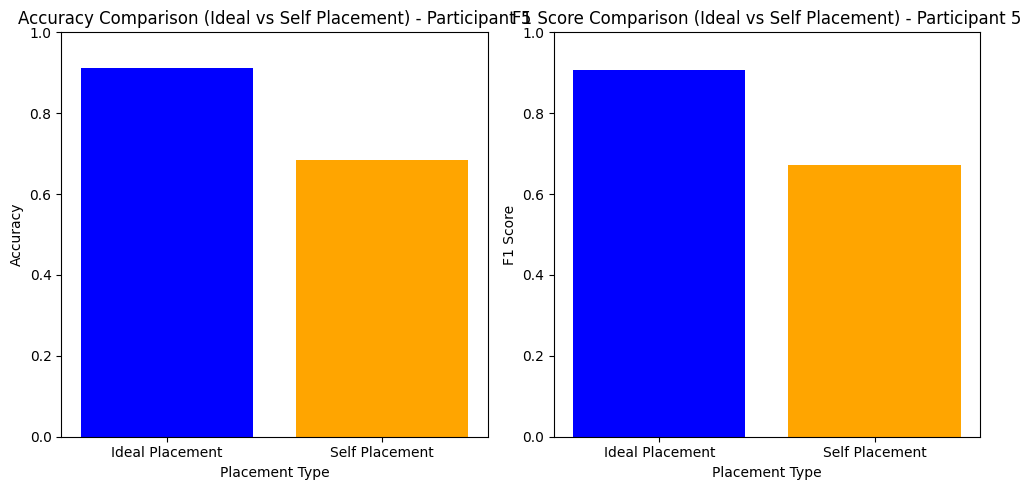

In [ ]:
#@title  Define the participant to leave out = 5 (with window analysis)
participant_id = '5'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")


# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)
print(f"Shape of X_ideal_train (Excluding Participant {participant_id}):", X_ideal_train.shape)
print(f"Shape of y_ideal_train (Excluding Participant {participant_id}):", y_ideal_train.shape)
print(f"Shape of X_self_train (Excluding Participant {participant_id}):", X_self_train.shape)
print(f"Shape of y_self_train (Excluding Participant {participant_id}):", y_self_train.shape)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)
print(f"Shape after standardizing X_ideal_train: {X_ideal_train.shape}")
print(f"Shape after standardizing X_self_train: {X_self_train.shape}")

# Load and preprocess test data for the left-out participant
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)
print(f"Shape of X_ideal_test (Participant {participant_id}):", X_ideal_test.shape)
print(f"Shape of y_ideal_test (Participant {participant_id}):", y_ideal_test.shape)
print(f"Shape of X_self_test (Participant {participant_id}):", X_self_test.shape)
print(f"Shape of y_self_test (Participant {participant_id}):", y_self_test.shape)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)
print(f"Shape after standardizing X_ideal_test: {X_ideal_test.shape}")
print(f"Shape after standardizing X_self_test: {X_self_test.shape}")

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)
print(f"Shape of X_ideal_windows_train: {X_ideal_windows_train.shape}")
print(f"Shape of y_ideal_windows_train: {y_ideal_windows_train.shape}")
print(f"Shape of X_self_windows_train: {X_self_windows_train.shape}")
print(f"Shape of y_self_windows_train: {y_self_windows_train.shape}")

# Create sliding windows for testing data (Participant 5)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)
print(f"Shape of X_ideal_windows_test: {X_ideal_windows_test.shape}")
print(f"Shape of y_ideal_windows_test: {y_ideal_windows_test.shape}")
print(f"Shape of X_self_windows_test: {X_self_windows_test.shape}")
print(f"Shape of y_self_windows_test: {y_self_windows_test.shape}")

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)
X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)
X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

print(f"Shape of X_ideal_tensor_train: {X_ideal_tensor_train.shape}")
print(f"Shape of y_ideal_tensor_train: {y_ideal_tensor_train.shape}")
print(f"Shape of X_ideal_tensor_test: {X_ideal_tensor_test.shape}")
print(f"Shape of y_ideal_tensor_test: {y_ideal_tensor_test.shape}")
print(f"Shape of X_self_tensor_test: {X_self_tensor_test.shape}")
print(f"Shape of y_self_tensor_test: {y_self_tensor_test.shape}")

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}")

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)
print(f"Number of classes: {num_classes}")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 5
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant {participant_id} Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 5
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant {participant_id} Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Comparison (Ideal vs Self Placement) - Participant {participant_id}')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title(f'F1 Score Comparison (Ideal vs Self Placement) - Participant {participant_id}')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 4): 16
Training Self Files (Excluding Participant 4): 16
Testing Ideal Files (Participant 4): 1
Testing Self Files (Participant 4): 1
Testing Ideal File Name(s) for Participant 4: ['subject4_ideal.log']
Testing Self File Name(s) for Participant 4: ['subject4_self.log']


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 540.9763, Val Loss: 51.5907, Val Accuracy: 0.9276
Participant 4 Ideal Placement Accuracy: 0.8621, F1 Score: 0.8398
Participant 4 Self-Placement Accuracy: 0.8515, F1 Score: 0.8427


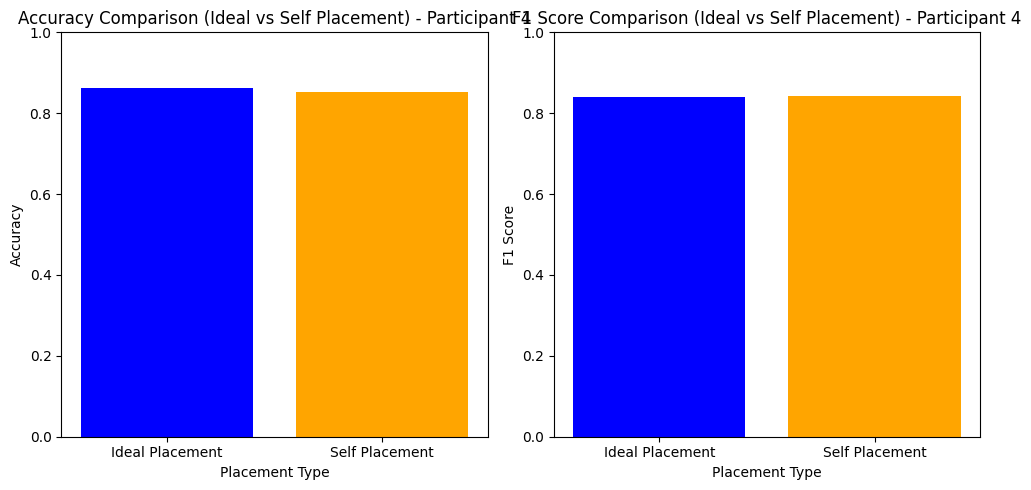

In [ ]:
#@title Participant left out = 4
# Define the participant to leave out
participant_id = '4'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 4 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 4 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 4')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 4')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 3): 16
Training Self Files (Excluding Participant 3): 16
Testing Ideal Files (Participant 3): 1
Testing Self Files (Participant 3): 1
Testing Ideal File Name(s) for Participant 3: ['subject3_ideal.log']
Testing Self File Name(s) for Participant 3: ['subject3_self.log']


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 538.5807, Val Loss: 55.1994, Val Accuracy: 0.9134
Participant 3 Ideal Placement Accuracy: 0.8313, F1 Score: 0.8102
Participant 3 Self-Placement Accuracy: 0.8752, F1 Score: 0.8703


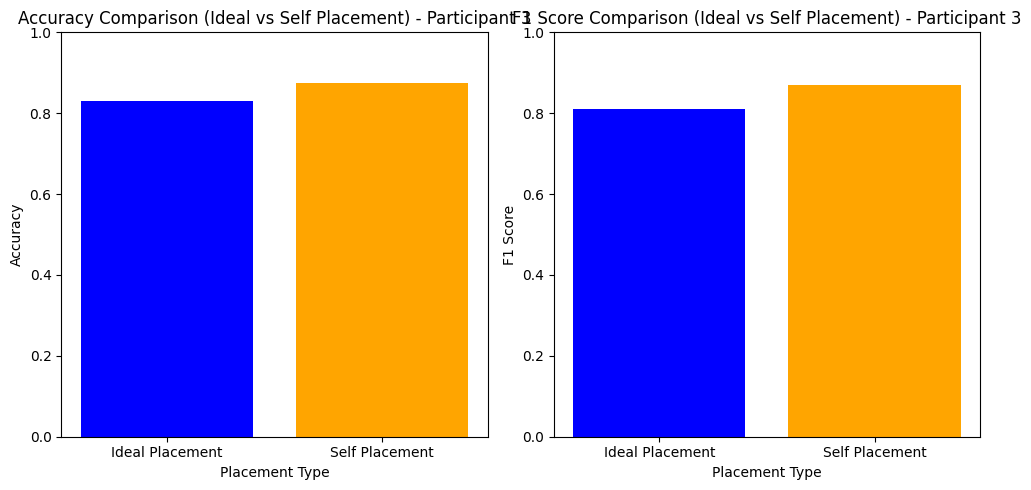

In [ ]:
#@title Participant left out = 3
# Define the participant to leave out
participant_id = '3'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 3 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 3 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 3')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 3')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 2): 16
Training Self Files (Excluding Participant 2): 16
Testing Ideal Files (Participant 2): 1
Testing Self Files (Participant 2): 1
Testing Ideal File Name(s) for Participant 2: ['subject2_ideal.log']
Testing Self File Name(s) for Participant 2: ['subject2_self.log']


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 546.4365, Val Loss: 52.0725, Val Accuracy: 0.9234
Participant 2 Ideal Placement Accuracy: 0.9282, F1 Score: 0.9266
Participant 2 Self-Placement Accuracy: 0.9082, F1 Score: 0.8986


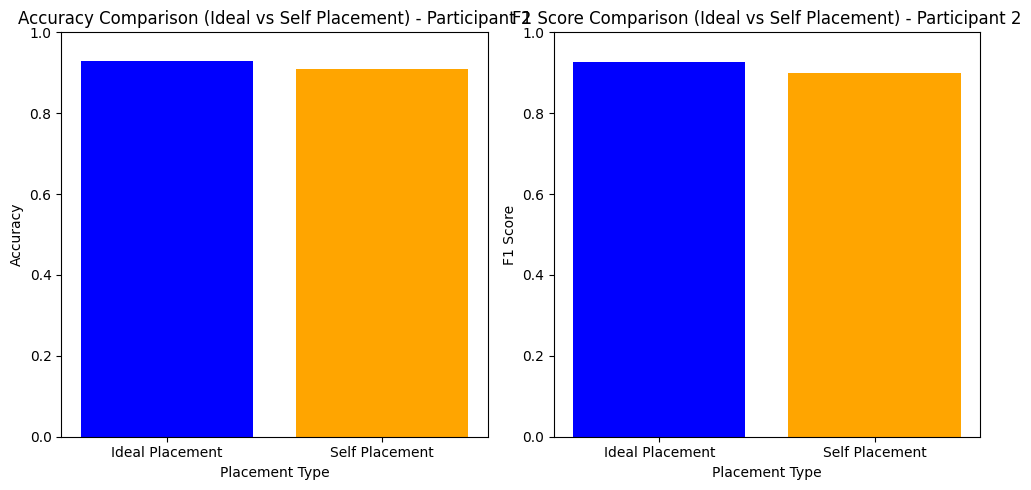

In [ ]:
#@title Participant left out = 2
# Define the participant to leave out
participant_id = '2'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 2 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 2 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 2')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 2')

plt.tight_layout()
plt.show()


Training Ideal Files (Excluding Participant 1): 16
Training Self Files (Excluding Participant 1): 16
Testing Ideal Files (Participant 1): 1
Testing Self Files (Participant 1): 1
Testing Ideal File Name(s) for Participant 1: ['subject1_ideal.log']
Testing Self File Name(s) for Participant 1: ['subject1_self.log']


<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6d>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)
<ipython-input-5-8c5a7cd72b6

131 Weights loaded
Epoch 1/1, Loss: 529.9338, Val Loss: 49.2540, Val Accuracy: 0.9222
Participant 1 Ideal Placement Accuracy: 0.9136, F1 Score: 0.9076
Participant 1 Self-Placement Accuracy: 0.9241, F1 Score: 0.9134


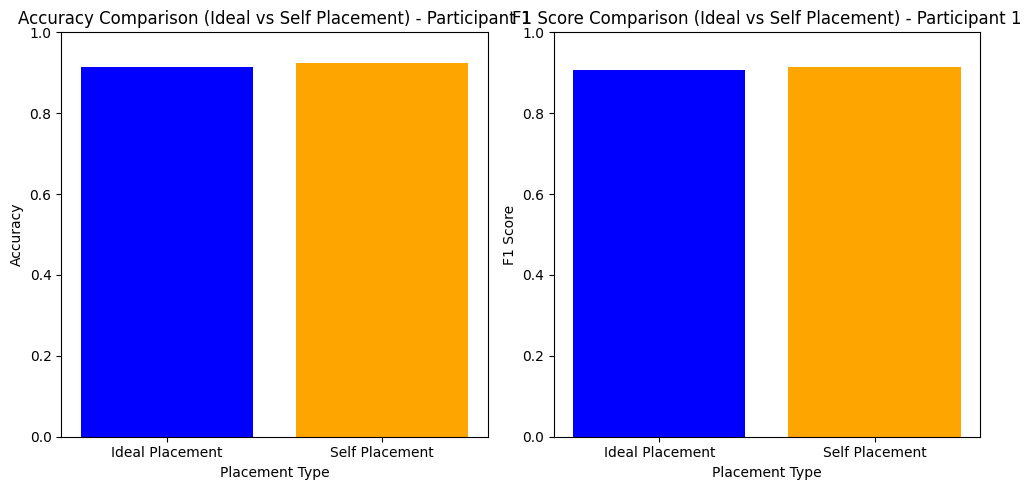

In [ ]:
#@title Participant left out = 1
# Define the participant to leave out
participant_id = '1'

# Separate files for training and testing with precise matching
ideal_files = [f for f in os.listdir(dataset_path) if f'_ideal.log' in f and f'subject{participant_id}_ideal.log' not in f]
self_files = [f for f in os.listdir(dataset_path) if f'_self.log' in f and f'subject{participant_id}_self.log' not in f]
ideal_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_ideal.log' == f]
self_test_files = [f for f in os.listdir(dataset_path) if f'subject{participant_id}_self.log' == f]


print(f"Training Ideal Files (Excluding Participant {participant_id}):", len(ideal_files))
print(f"Training Self Files (Excluding Participant {participant_id}):", len(self_files))
print(f"Testing Ideal Files (Participant {participant_id}):", len(ideal_test_files))
print(f"Testing Self Files (Participant {participant_id}):", len(self_test_files))


# Print the names of the testing files
print(f"Testing Ideal File Name(s) for Participant {participant_id}: {ideal_test_files}")
print(f"Testing Self File Name(s) for Participant {participant_id}: {self_test_files}")

# Load and preprocess training data
X_ideal_train, y_ideal_train, X_self_train, y_self_train = prepare_data_for_model(ideal_files, self_files)

# Standardize the training data
scaler = StandardScaler()
X_ideal_train = scaler.fit_transform(X_ideal_train)
X_self_train = scaler.transform(X_self_train)

# Load and preprocess test data (Participant 13)
X_ideal_test, y_ideal_test, X_self_test, y_self_test = prepare_data_for_model(ideal_test_files, self_test_files)

# Standardize the test data using the training scaler
X_ideal_test = scaler.transform(X_ideal_test)
X_self_test = scaler.transform(X_self_test)

# Create sliding windows for training data
X_ideal_windows_train, y_ideal_windows_train = create_windows(X_ideal_train, y_ideal_train)
X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)

# Create sliding windows for testing data (Participant 13)
X_ideal_windows_test, y_ideal_windows_test = create_windows(X_ideal_test, y_ideal_test)
X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

# Convert to PyTorch tensors
X_ideal_tensor_train = torch.FloatTensor(X_ideal_windows_train)
y_ideal_tensor_train = torch.LongTensor(y_ideal_windows_train)

X_ideal_tensor_test = torch.FloatTensor(X_ideal_windows_test)
y_ideal_tensor_test = torch.LongTensor(y_ideal_windows_test)

X_self_tensor_test = torch.FloatTensor(X_self_windows_test)
y_self_tensor_test = torch.LongTensor(y_self_windows_test)

# Train-test split for ideal training data
X_train, X_val, y_train, y_val = train_test_split(X_ideal_tensor_train, y_ideal_tensor_train, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load the pretrained HaRNet10 model
repo = 'OxWearables/ssl-wearables'
model = torch.hub.load(repo, 'harnet10', pretrained=True)

# Adjust the classifier for fine-tuning
num_classes = len(torch.unique(y_ideal_tensor_train))
if hasattr(model, 'classifier'):
    in_features = model.classifier.linear1.in_features
    model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    val_accuracy /= len(val_dataset)
    train_losses.append(running_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the Ideal Placement Test Data for Participant 9
model.eval()
with torch.no_grad():
    outputs = model(X_ideal_tensor_test)
    _, predicted = torch.max(outputs, 1)
    ideal_accuracy = (predicted == y_ideal_tensor_test).sum().item() / len(y_ideal_tensor_test)
    ideal_f1 = f1_score(y_ideal_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 1 Ideal Placement Accuracy: {ideal_accuracy:.4f}, F1 Score: {ideal_f1:.4f}')

# Evaluate on the Self-Placement Test Data for Participant 9
with torch.no_grad():
    outputs = model(X_self_tensor_test)
    _, predicted = torch.max(outputs, 1)
    self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
    self_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

print(f'Participant 1 Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {self_f1:.4f}')

# Visualization
placement_types = ['Ideal Placement', 'Self Placement']
accuracies = [ideal_accuracy, self_accuracy]
f1_scores = [ideal_f1, self_f1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(placement_types, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (Ideal vs Self Placement) - Participant 1')

plt.subplot(1, 2, 2)
plt.bar(placement_types, f1_scores, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Placement Type')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison (Ideal vs Self Placement) - Participant 1')

plt.tight_layout()
plt.show()


   Participant_id  Ideal Placement Accuracy  Ideal_F1 Score  \
0               1                    0.9136          0.9076   
1               2                    0.9282          0.9266   
2               3                    0.8313          0.8102   
3               4                    0.8621          0.8398   
4               5                    0.9128          0.9073   

   Self-Placement Accuracy  Self_F1 Score  Unnamed: 5  Unnamed: 6  Unnamed: 7  \
0                   0.9241         0.9134         NaN         NaN         NaN   
1                   0.9082         0.8986         NaN         NaN         NaN   
2                   0.8752         0.8703         NaN         NaN         NaN   
3                   0.8515         0.8427         NaN         NaN         NaN   
4                   0.6838         0.6719         NaN         NaN         NaN   

   Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  
0         NaN         NaN          NaN          NaN  
1         NaN         NaN 

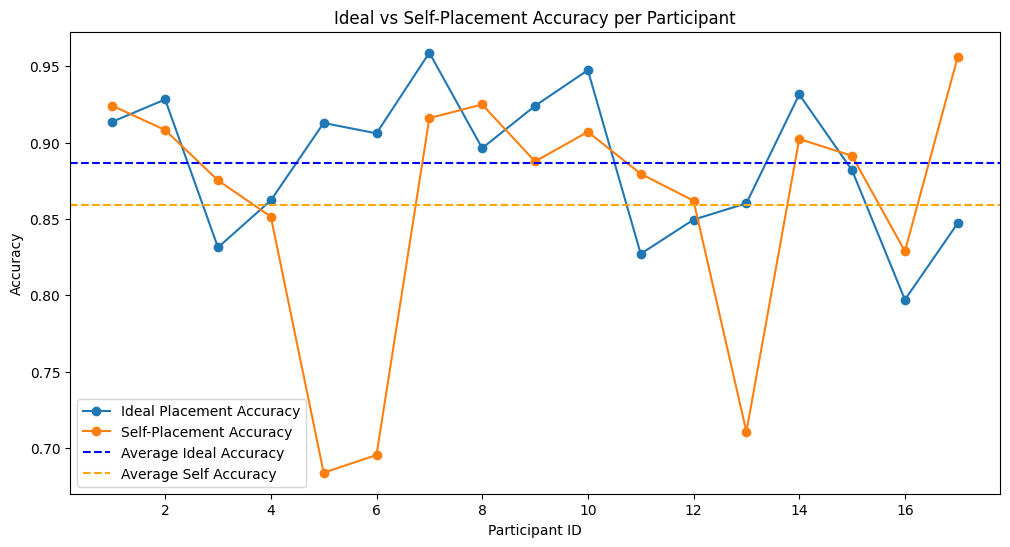

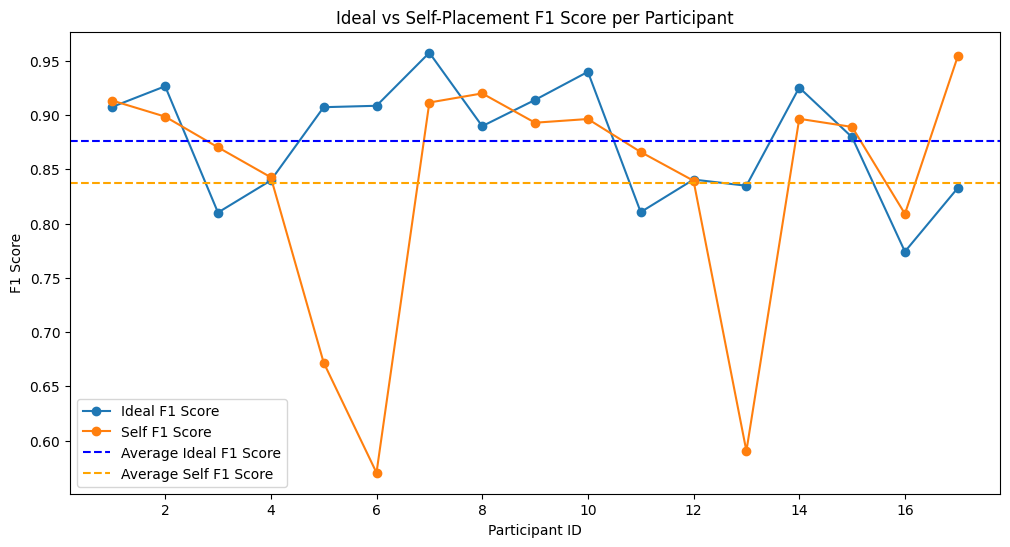

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
data = pd.read_csv("REALDISP_VALUES.csv")

# Display the data
print(data.head())

# Calculate averages
average_ideal_accuracy = data["Ideal Placement Accuracy"].mean()
average_self_accuracy = data["Self-Placement Accuracy"].mean()
average_ideal_f1 = data["Ideal_F1 Score"].mean()
average_self_f1 = data["Self_F1 Score"].mean()

# Print averages
print("Average Ideal Placement Accuracy:", average_ideal_accuracy)
print("Average Self-Placement Accuracy:", average_self_accuracy)
print("Average Ideal F1 Score:", average_ideal_f1)
print("Average Self F1 Score:", average_self_f1)

# Plot Ideal vs Self-Placement Accuracy
plt.figure(figsize=(12, 6))
plt.plot(data["Participant_id"], data["Ideal Placement Accuracy"], label="Ideal Placement Accuracy", marker='o')
plt.plot(data["Participant_id"], data["Self-Placement Accuracy"], label="Self-Placement Accuracy", marker='o')
plt.axhline(y=average_ideal_accuracy, color='blue', linestyle='--', label="Average Ideal Accuracy")
plt.axhline(y=average_self_accuracy, color='orange', linestyle='--', label="Average Self Accuracy")
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.title("Ideal vs Self-Placement Accuracy per Participant")
plt.legend()
plt.show()

# Plot Ideal vs Self-Placement F1 Scores
plt.figure(figsize=(12, 6))
plt.plot(data["Participant_id"], data["Ideal_F1 Score"], label="Ideal F1 Score", marker='o')
plt.plot(data["Participant_id"], data["Self_F1 Score"], label="Self F1 Score", marker='o')
plt.axhline(y=average_ideal_f1, color='blue', linestyle='--', label="Average Ideal F1 Score")
plt.axhline(y=average_self_f1, color='orange', linestyle='--', label="Average Self F1 Score")
plt.xlabel("Participant ID")
plt.ylabel("F1 Score")
plt.title("Ideal vs Self-Placement F1 Score per Participant")
plt.legend()
plt.show()


    Participant_id  Ideal Placement Accuracy  Ideal_F1 Score  \
0                1                    0.8540          0.8351   
1                2                    0.9004          0.8967   
2                3                    0.8280          0.8056   
3                4                    0.9259          0.9167   
4                5                    0.8963          0.8904   
5                6                    0.8672          0.8606   
6                7                    0.9094          0.8927   
7                8                    0.8963          0.8898   
8                9                    0.9240          0.9140   
9               10                    0.9474          0.9399   
10              11                    0.8271          0.8106   
11              12                    0.8495          0.8406   
12              13                    0.8602          0.8349   
13              14                    0.9315          0.9254   
14              15                    0.

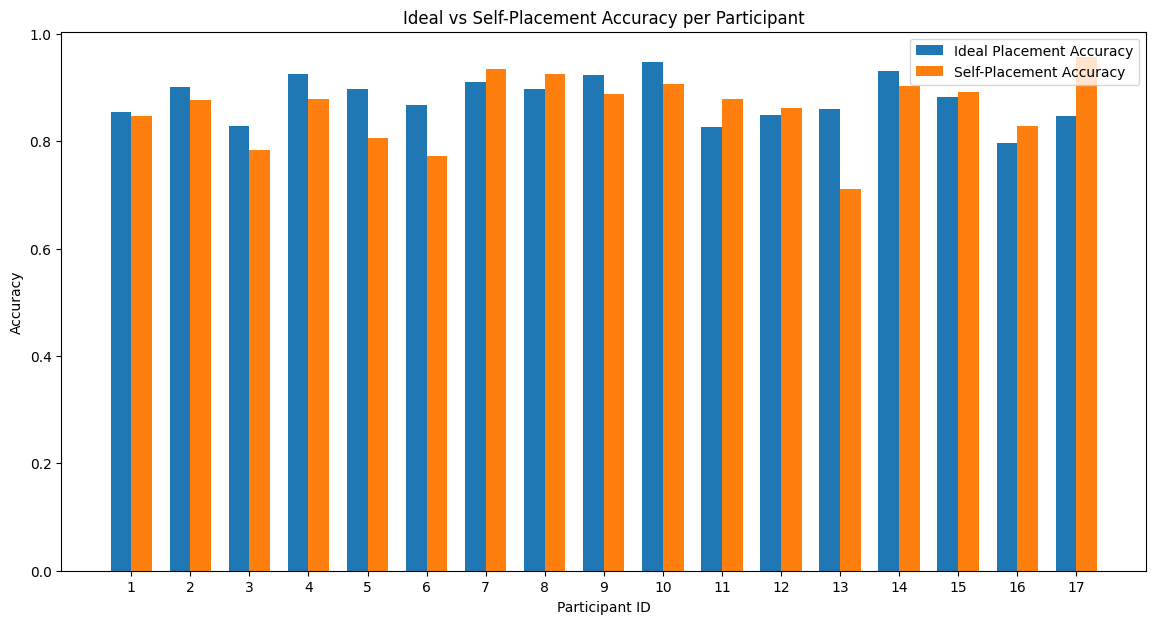

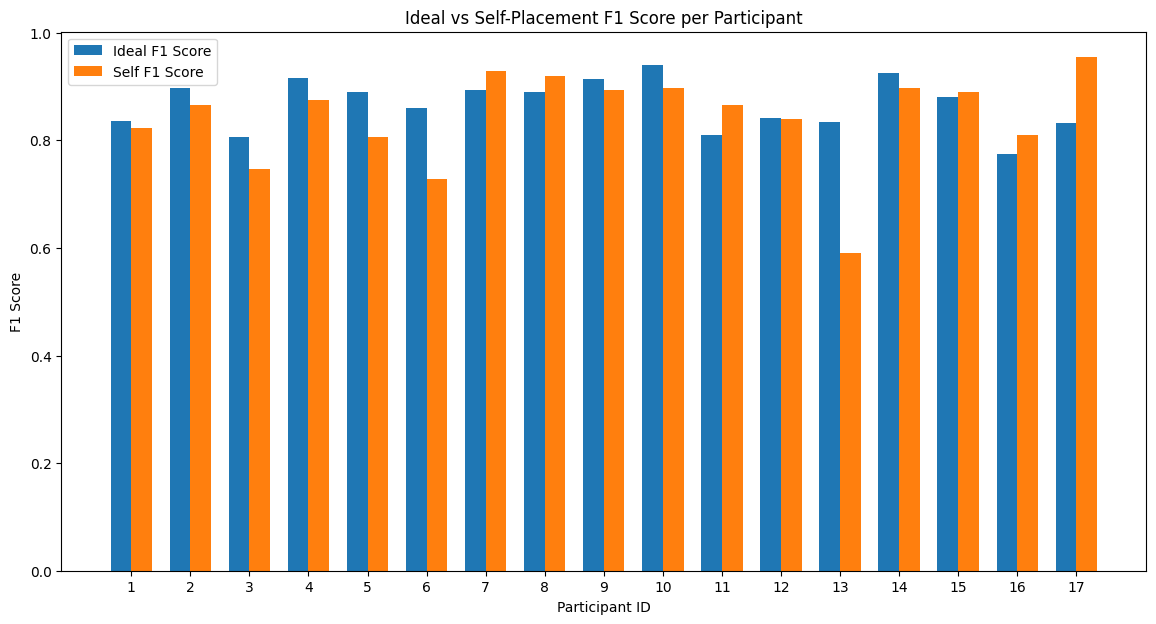

Average Ideal Accuracy: 0.88%
Average Self Accuracy: 0.86%
Average Ideal F1 Score: 0.87%
Average Self F1 Score: 0.84%


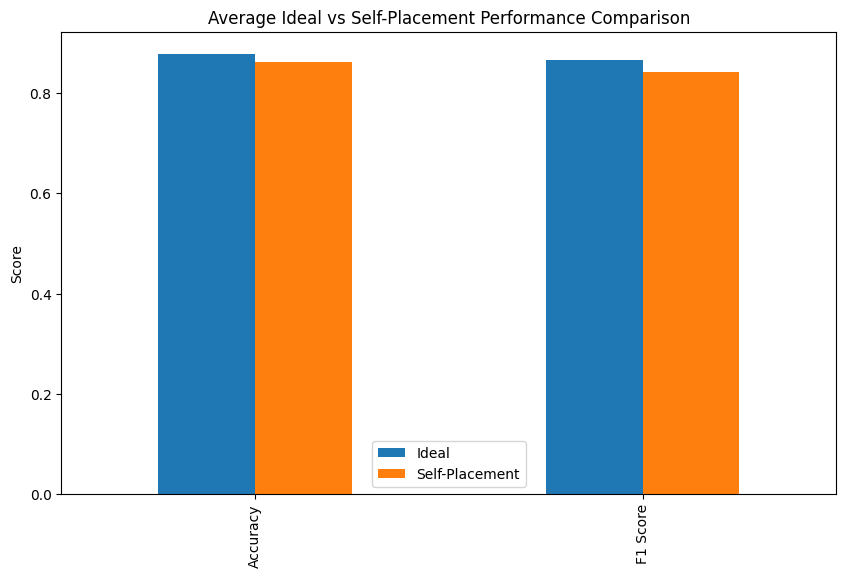

Accuracy depreciation: 1.96%
F1 Score depreciation: 2.81%


In [ ]:
#@title  visualtization(old)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
data = pd.read_csv("REALDISP_VALUES.csv")

# Display the data
print(data)

# Calculate averages
average_ideal_accuracy = data["Ideal Placement Accuracy"].mean()
average_self_accuracy = data["Self-Placement Accuracy"].mean()
average_ideal_f1 = data["Ideal_F1 Score"].mean()
average_self_f1 = data["Self_F1 Score"].mean()



# Bar chart for each participant's Ideal vs Self-Placement Accuracy
plt.figure(figsize=(14, 7))
x = np.arange(len(data["Participant_id"]))  # the label locations
width = 0.35  # the width of the bars

# Plot Ideal and Self-Placement Accuracy
plt.bar(x - width/2, data["Ideal Placement Accuracy"], width, label="Ideal Placement Accuracy")
plt.bar(x + width/2, data["Self-Placement Accuracy"], width, label="Self-Placement Accuracy")

# Labels and titles
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.title("Ideal vs Self-Placement Accuracy per Participant")
plt.xticks(x, data["Participant_id"])
plt.legend()
plt.show()

# Bar chart for each participant's Ideal vs Self-Placement F1 Scores
plt.figure(figsize=(14, 7))
# Plot Ideal and Self-Placement F1 Scores
plt.bar(x - width/2, data["Ideal_F1 Score"], width, label="Ideal F1 Score")
plt.bar(x + width/2, data["Self_F1 Score"], width, label="Self F1 Score")

# Labels and titles
plt.xlabel("Participant ID")
plt.ylabel("F1 Score")
plt.title("Ideal vs Self-Placement F1 Score per Participant")
plt.xticks(x, data["Participant_id"])
plt.legend()
plt.show()

# Separate bar chart for average comparison of Ideal vs Self for Accuracy and F1 Score
averages = {
    "Ideal": [average_ideal_accuracy, average_ideal_f1],
    "Self-Placement": [average_self_accuracy, average_self_f1]
}
average_df = pd.DataFrame(averages, index=["Accuracy", "F1 Score"])


print(f"Average Ideal Accuracy: {average_ideal_accuracy:.2f}%")
print(f"Average Self Accuracy: {average_self_accuracy:.2f}%")
print(f"Average Ideal F1 Score: {average_ideal_f1:.2f}%")
print(f"Average Self F1 Score: {average_self_f1:.2f}%")


# Plot average comparison
average_df.plot(kind="bar", figsize=(10, 6))
plt.title("Average Ideal vs Self-Placement Performance Comparison")
plt.ylabel("Score")
plt.show()

# Calculate and print depreciation in values
accuracy_depreciation = (average_ideal_accuracy - average_self_accuracy) / average_ideal_accuracy * 100
f1_depreciation = (average_ideal_f1 - average_self_f1) / average_ideal_f1 * 100

print(f"Accuracy depreciation: {accuracy_depreciation:.2f}%")
print(f"F1 Score depreciation: {f1_depreciation:.2f}%")


    Participant_id  Ideal Placement Accuracy  Ideal_F1 Score  \
0                1                    0.9136          0.9076   
1                2                    0.9282          0.9266   
2                3                    0.8313          0.8102   
3                4                    0.8621          0.8398   
4                5                    0.9128          0.9073   
5                6                    0.9060          0.9086   
6                7                    0.9588          0.9575   
7                8                    0.8963          0.8898   
8                9                    0.9240          0.9140   
9               10                    0.9474          0.9399   
10              11                    0.8271          0.8106   
11              12                    0.8495          0.8406   
12              13                    0.8602          0.8349   
13              14                    0.9315          0.9254   
14              15                    0.

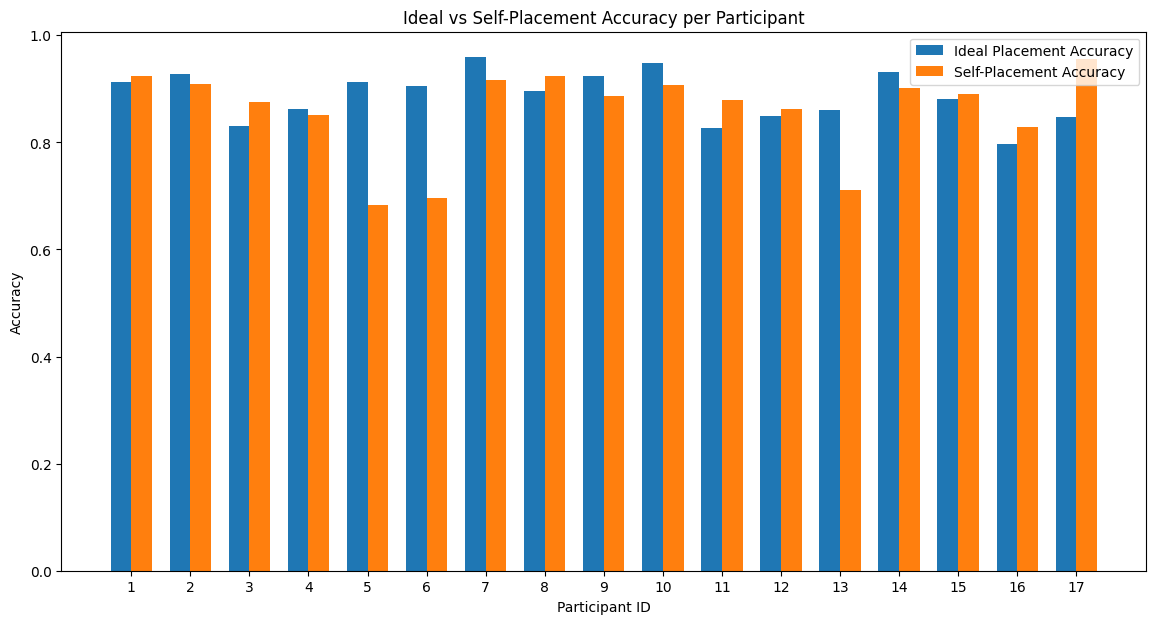

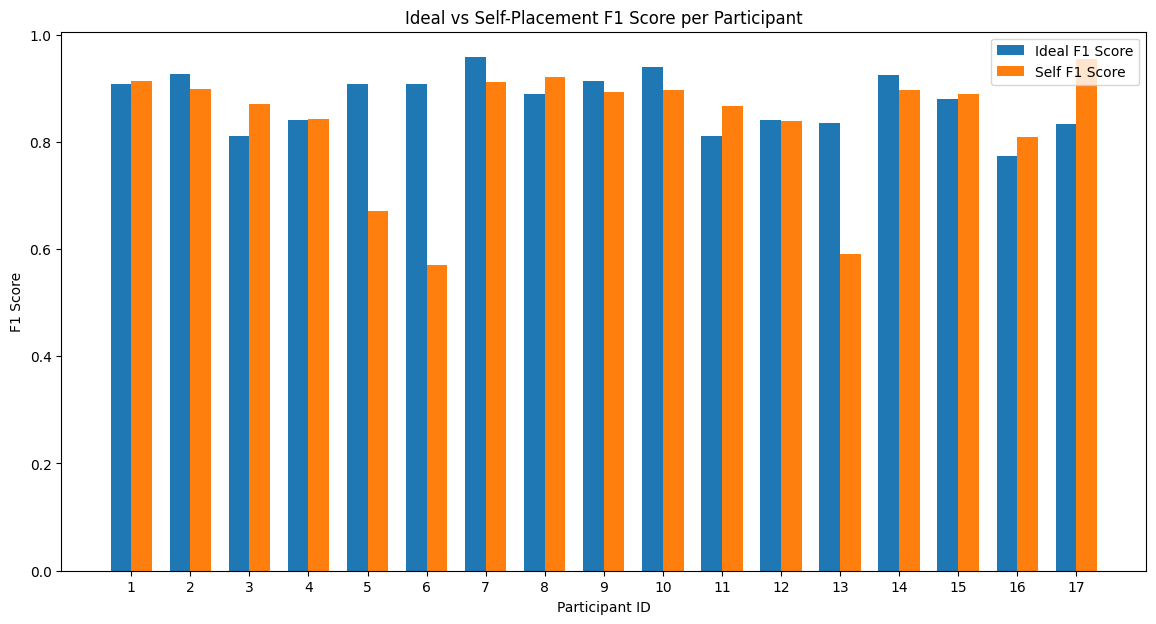

Average Ideal Accuracy: 0.89%
Average Self Accuracy: 0.86%
Average Ideal F1 Score: 0.88%
Average Self F1 Score: 0.84%


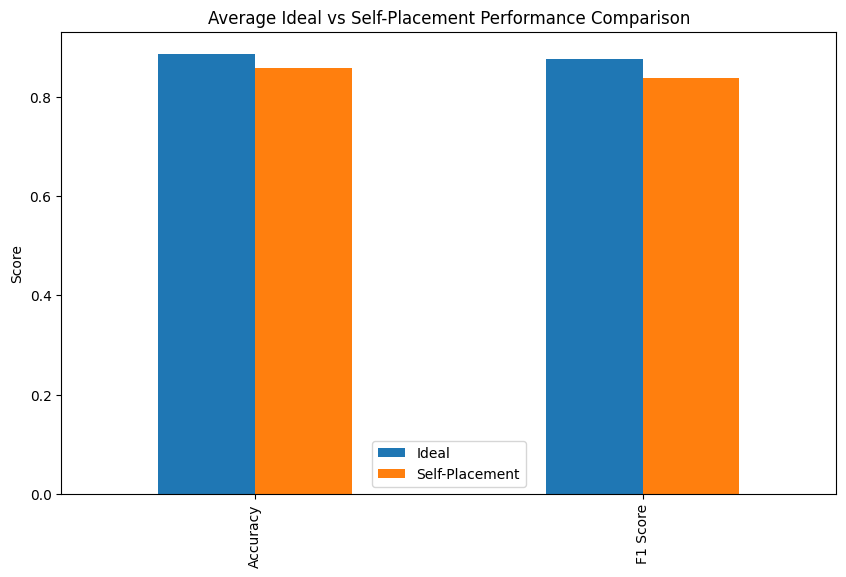

Accuracy depreciation: 3.12%
F1 Score depreciation: 4.47%


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
data = pd.read_csv("REALDISP_VALUES.csv")

# Display the data
print(data)

# Calculate averages
average_ideal_accuracy = data["Ideal Placement Accuracy"].mean()
average_self_accuracy = data["Self-Placement Accuracy"].mean()
average_ideal_f1 = data["Ideal_F1 Score"].mean()
average_self_f1 = data["Self_F1 Score"].mean()



# Bar chart for each participant's Ideal vs Self-Placement Accuracy
plt.figure(figsize=(14, 7))
x = np.arange(len(data["Participant_id"]))  # the label locations
width = 0.35  # the width of the bars

# Plot Ideal and Self-Placement Accuracy
plt.bar(x - width/2, data["Ideal Placement Accuracy"], width, label="Ideal Placement Accuracy")
plt.bar(x + width/2, data["Self-Placement Accuracy"], width, label="Self-Placement Accuracy")

# Labels and titles
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.title("Ideal vs Self-Placement Accuracy per Participant")
plt.xticks(x, data["Participant_id"])
plt.legend()
plt.show()

# Bar chart for each participant's Ideal vs Self-Placement F1 Scores
plt.figure(figsize=(14, 7))
# Plot Ideal and Self-Placement F1 Scores
plt.bar(x - width/2, data["Ideal_F1 Score"], width, label="Ideal F1 Score")
plt.bar(x + width/2, data["Self_F1 Score"], width, label="Self F1 Score")

# Labels and titles
plt.xlabel("Participant ID")
plt.ylabel("F1 Score")
plt.title("Ideal vs Self-Placement F1 Score per Participant")
plt.xticks(x, data["Participant_id"])
plt.legend()
plt.show()

# Separate bar chart for average comparison of Ideal vs Self for Accuracy and F1 Score
averages = {
    "Ideal": [average_ideal_accuracy, average_ideal_f1],
    "Self-Placement": [average_self_accuracy, average_self_f1]
}
average_df = pd.DataFrame(averages, index=["Accuracy", "F1 Score"])


print(f"Average Ideal Accuracy: {average_ideal_accuracy:.2f}%")
print(f"Average Self Accuracy: {average_self_accuracy:.2f}%")
print(f"Average Ideal F1 Score: {average_ideal_f1:.2f}%")
print(f"Average Self F1 Score: {average_self_f1:.2f}%")


# Plot average comparison
average_df.plot(kind="bar", figsize=(10, 6))
plt.title("Average Ideal vs Self-Placement Performance Comparison")
plt.ylabel("Score")
plt.show()

# Calculate and print depreciation in values
accuracy_depreciation = (average_ideal_accuracy - average_self_accuracy) / average_ideal_accuracy * 100
f1_depreciation = (average_ideal_f1 - average_self_f1) / average_ideal_f1 * 100

print(f"Accuracy depreciation: {accuracy_depreciation:.2f}%")
print(f"F1 Score depreciation: {f1_depreciation:.2f}%")


Participant Wise analysis starts below ( Self train - Self test)

In [ ]:
# Example usage
anomaly_files = [
    "subject5_ideal.log", "subject5_self.log",
    "subject6_ideal.log", "subject6_self.log",
    "subject13_ideal.log", "subject13_self.log"
]
dataset_path = './dataset'


In [ ]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import resample

# Define columns of interest based on the manual
LLA_ACC_X = 55
LLA_ACC_Y = 56
LLA_ACC_Z = 57
ACTIVITY_LABEL = -1  # Last column is activity label

def load_realdisp_data(file_path, sensor_columns):
    """Load data from a REALDISP .log file and extract relevant sensor columns and activity labels."""
    # Load the log file using pandas, skipping timestamp columns
    df = pd.read_csv(file_path, sep='\s+', header=None)  # Fixing FutureWarning
    lla_data = df.iloc[:, sensor_columns].values
    labels = df.iloc[:, ACTIVITY_LABEL].values
    return lla_data, labels

def resample_data(X, original_frequency, target_frequency):
    """
    Resample the data to the target frequency.

    Args:
        X (numpy.ndarray): Input data (time-series).
        original_frequency (int): Original sampling frequency (e.g., 50 Hz).
        target_frequency (int): Target sampling frequency (e.g., 30 Hz).

    Returns:
        numpy.ndarray: Resampled data.
    """
    num_samples = int(X.shape[0] * target_frequency / original_frequency)
    resampled_X = resample(X, num_samples, axis=0)
    return resampled_X

def prepare_data_for_model(ideal_files, self_files, original_frequency=50, target_frequency=30):
    """Load and prepare the dataset for HaRNet10 from both ideal and self-placement files."""
    X_ideal, y_ideal = [], []
    X_self, y_self = [], []

    for file in ideal_files:
        lla_data, labels = load_realdisp_data(os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z])
        lla_data = resample_data(lla_data, original_frequency, target_frequency)  # Resample data
        X_ideal.append(lla_data)
        y_ideal.append(labels[:lla_data.shape[0]])  # Ensure labels match resampled length

    for file in self_files:
        lla_data, labels = load_realdisp_data(os.path.join(dataset_path, file), [LLA_ACC_X, LLA_ACC_Y, LLA_ACC_Z])
        lla_data = resample_data(lla_data, original_frequency, target_frequency)  # Resample data
        X_self.append(lla_data)
        y_self.append(labels[:lla_data.shape[0]])  # Ensure labels match resampled length

    # Stack the data into arrays
    X_ideal = np.vstack(X_ideal) if X_ideal else np.empty((0, 3))
    y_ideal = np.hstack(y_ideal) if y_ideal else np.empty((0,))
    X_self = np.vstack(X_self) if X_self else np.empty((0, 3))
    y_self = np.hstack(y_self) if y_self else np.empty((0,))

    return X_ideal, y_ideal, X_self, y_self

def create_windows(X, y, window_size=300, overlap=0.5):
    """Create sliding windows from the data with overlap."""
    step = int(window_size * (1 - overlap))
    features = []
    labels = []

    for i in range(0, len(X) - window_size, step):
        window = X[i:i + window_size].T  # Shape as (channels, sequence_length)
        label = y[i + window_size // 2]  # Take the middle label
        features.append(window)
        labels.append(label)

    return np.array(features), np.array(labels)

def train_and_evaluate_self(participant_id, dataset_path, anomaly_files=[], num_epochs=1, batch_size=16):
    """
    Train the model on self-placement training data (excluding anomaly files) and test on the left-out participant's self-placement data.
    """
    # Separate files for training and testing, excluding anomalies
    self_files = [
        f for f in os.listdir(dataset_path)
        if '_self.log' in f and f.split('_')[0] != f"subject{participant_id}" and f not in anomaly_files
    ]
    self_test_files = [
        f for f in os.listdir(dataset_path)
        if '_self.log' in f and f.split('_')[0] == f"subject{participant_id}" and f not in anomaly_files
    ]

    # Debug: Print the filtered files
    print(f"Training Files (Self): {self_files}")
    print(f"Testing Files (Self): {self_test_files}")

    # Load and preprocess training data
    _, _, X_self_train, y_self_train = prepare_data_for_model([], self_files)
    print(f"Training Data Shapes - Features: {X_self_train.shape}, Labels: {y_self_train.shape}")

    # Standardize the training data
    scaler = StandardScaler()
    X_self_train = scaler.fit_transform(X_self_train)

    # Load and preprocess test data (Participant ID)
    _, _, X_self_test, y_self_test = prepare_data_for_model([], self_test_files)
    print(f"Test Data Shapes - Features: {X_self_test.shape}, Labels: {y_self_test.shape}")

    # Standardize the test data using the training scaler
    X_self_test = scaler.transform(X_self_test)

    # Create sliding windows for training and testing data
    X_self_windows_train, y_self_windows_train = create_windows(X_self_train, y_self_train)
    X_self_windows_test, y_self_windows_test = create_windows(X_self_test, y_self_test)

    print(f"Sliding Window Shapes - Training: {X_self_windows_train.shape}, Testing: {X_self_windows_test.shape}")

    # Encode labels to consecutive integers
    label_encoder = LabelEncoder()
    y_self_tensor_train = torch.LongTensor(label_encoder.fit_transform(y_self_windows_train))
    y_self_tensor_test = torch.LongTensor(label_encoder.transform(y_self_windows_test))

    # Convert to PyTorch tensors
    X_self_tensor_train = torch.FloatTensor(X_self_windows_train)
    X_self_tensor_test = torch.FloatTensor(X_self_windows_test)

    # Train-test split for self-training data
    X_train, X_val, y_train, y_val = train_test_split(X_self_tensor_train, y_self_tensor_train, test_size=0.2, random_state=42)

    # Create DataLoader for training and validation
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load the pretrained HaRNet10 model
    repo = 'OxWearables/ssl-wearables'
    model = torch.hub.load(repo, 'harnet10', pretrained=True)

    # Adjust the classifier for fine-tuning
    num_classes = len(torch.unique(y_self_tensor_train))
    if hasattr(model, 'classifier'):
        in_features = model.classifier.linear1.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_accuracy = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_accuracy += (predicted == batch_y).sum().item()

        val_accuracy /= len(val_dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on the Self-Placement Test Data for the left-out participant
    # Evaluate on the Self-Placement Test Data for the left-out participant
    model.eval()
    with torch.no_grad():
        outputs = model(X_self_tensor_test)
        _, predicted = torch.max(outputs, 1)
        self_accuracy = (predicted == y_self_tensor_test).sum().item() / len(y_self_tensor_test)
        weighted_f1 = f1_score(y_self_tensor_test.cpu(), predicted.cpu(), average='weighted')

    print(f'Participant {participant_id} Self-Placement Accuracy: {self_accuracy:.4f}, F1 Score: {weighted_f1:.4f}')

    return model, self_accuracy, weighted_f1


In [ ]:

# Example usage
anomaly_files = [
    "subject5_ideal.log", "subject5_self.log",
    "subject6_ideal.log", "subject6_self.log",
    "subject13_ideal.log", "subject13_self.log"
]
dataset_path = './dataset'



Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject17_self.log']
Loaded file: ./dataset/subject11_self.log, Shape: (157079, 120)
Loaded file: ./dataset/subject7_self.log, Shape: (162693, 120)
Loaded file: ./dataset/subject15_self.log, Shape: (178231, 120)
Loaded file: ./dataset/subject4_self.log, Shape: (200176, 120)
Loaded file: ./dataset/subject16_self.log, Shape: (165779, 120)
Loaded file: ./dataset/subject2_self.log, Shape: (165232, 120)
Loaded file: ./dataset/subject8_self.log, Shape: (204121, 120)
Loaded file: ./dataset/subject3_self.log, Shape: (166167, 120)
Loaded file: ./dataset/subject10_self.log, Shape: (211500, 120)
Loaded file: ./dataset/subject12_self.log, Shape: (145765, 120)
Loaded file: ./da

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct mal

131 Weights loaded
Epoch 1/1, Loss: 514.1716, Val Loss: 46.4745, Val Accuracy: 0.9326
Participant 17 Self-Placement Accuracy: 0.9456, F1 Score: 0.9496


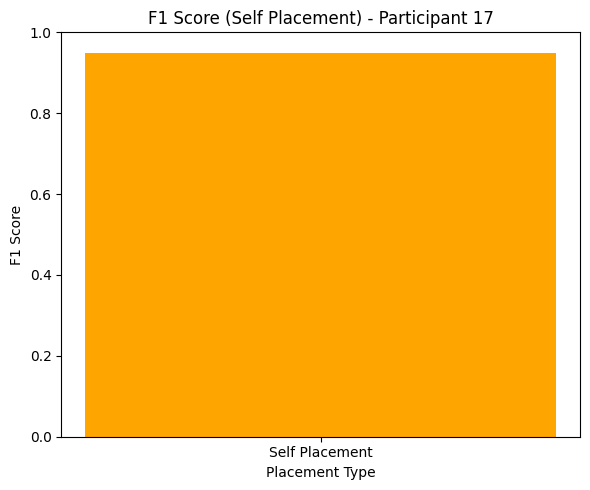

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Participant17 (self only)
model, accuracy, f1_score = train_and_evaluate_self(participant_id='17', dataset_path='./dataset', anomaly_files=anomaly_files, num_epochs=1)

Training Files (Self): ['subject12_self.log', 'subject4_self.log', 'subject17_self.log', 'subject15_self.log', 'subject1_self.log', 'subject7_self.log', 'subject10_self.log', 'subject14_self.log', 'subject9_self.log', 'subject2_self.log', 'subject11_self.log', 'subject8_self.log', 'subject3_self.log']
Testing Files (Self): ['subject16_self.log']
Training Data Shapes - Features: (2296131, 3), Labels: (2296131,)
Test Data Shapes - Features: (165779, 3), Labels: (165779,)
Sliding Window Shapes - Training: (15306, 3, 300), Testing: (1104, 3, 300)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct mal

131 Weights loaded
Epoch 1/1, Loss: 492.9476, Val Loss: 43.9117, Val Accuracy: 0.9197
Participant 16 Self-Placement Accuracy: 0.8514, F1 Score: 0.8451


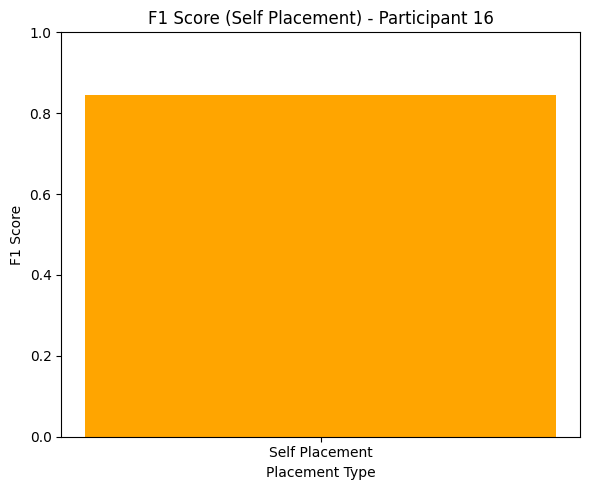

In [ ]:
#@title Participant16 (self only)
model, accuracy, f1_score = train_and_evaluate_self(participant_id='16', dataset_path='./dataset', anomaly_files=anomaly_files, num_epochs=1)

Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject15_self.log']
Training Data Shapes - Features: (2283679, 3), Labels: (2283679,)
Test Data Shapes - Features: (178231, 3), Labels: (178231,)
Sliding Window Shapes - Training: (15223, 3, 300), Testing: (1187, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 504.1904, Val Loss: 48.2268, Val Accuracy: 0.9146
Participant 15 Self-Placement Accuracy: 0.8770, F1 Score: 0.8645


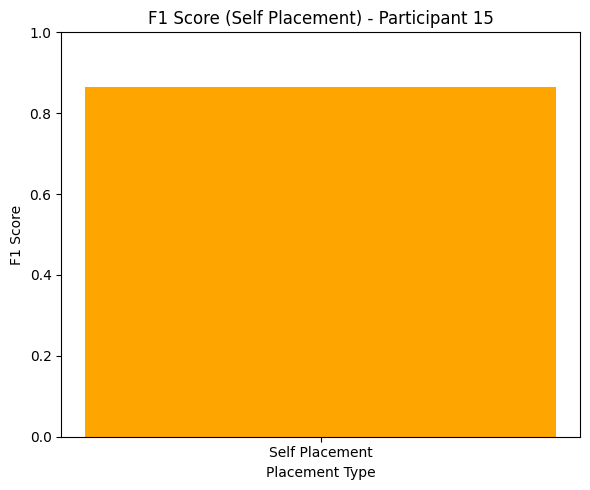

In [ ]:
#@title Participant left out = 15 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='15', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject9_self.log']
Testing Files (Self): ['subject14_self.log']
Training Data Shapes - Features: (2282100, 3), Labels: (2282100,)
Test Data Shapes - Features: (179810, 3), Labels: (179810,)
Sliding Window Shapes - Training: (15212, 3, 300), Testing: (1197, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 504.2420, Val Loss: 51.2428, Val Accuracy: 0.9185
Participant 14 Self-Placement Accuracy: 0.9282, F1 Score: 0.9260


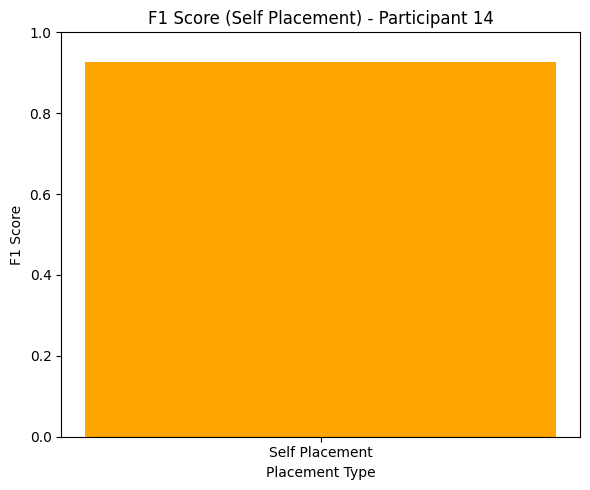

In [ ]:
#@title Participant left out = 14 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='14', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject12_self.log']
Training Data Shapes - Features: (2316145, 3), Labels: (2316145,)
Test Data Shapes - Features: (145765, 3), Labels: (145765,)
Sliding Window Shapes - Training: (15439, 3, 300), Testing: (970, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 499.8507, Val Loss: 39.9837, Val Accuracy: 0.9343
Participant 12 Self-Placement Accuracy: 0.8773, F1 Score: 0.8535


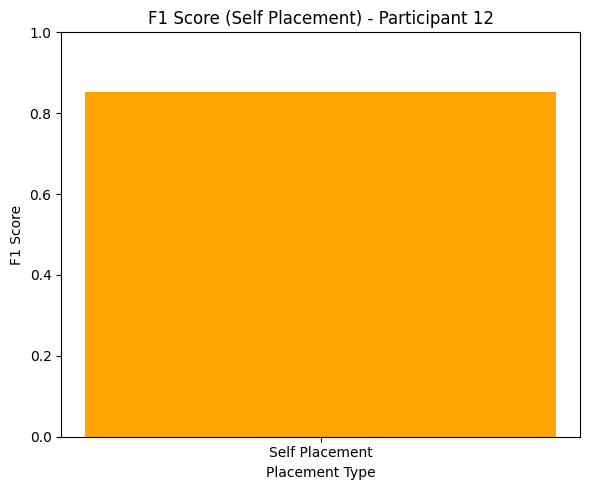

In [ ]:
#@title Participant left out = 12 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='12', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject11_self.log']
Training Data Shapes - Features: (2304831, 3), Labels: (2304831,)
Test Data Shapes - Features: (157079, 3), Labels: (157079,)
Sliding Window Shapes - Training: (15364, 3, 300), Testing: (1046, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 490.6169, Val Loss: 43.3187, Val Accuracy: 0.9261
Participant 11 Self-Placement Accuracy: 0.9159, F1 Score: 0.9007


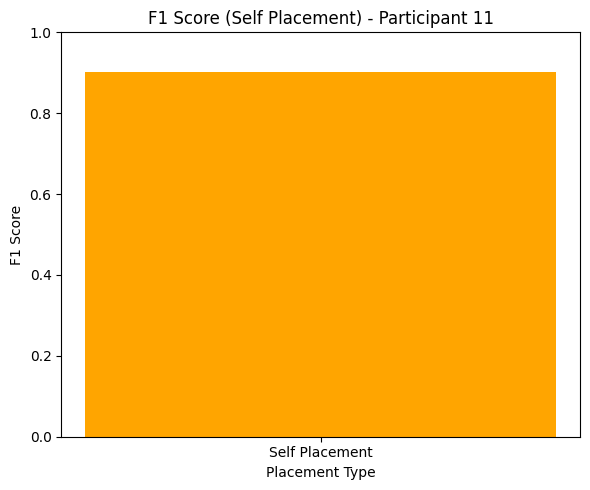

In [ ]:
#@title Participant left out = 11 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='11', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject10_self.log']
Training Data Shapes - Features: (2250410, 3), Labels: (2250410,)
Test Data Shapes - Features: (211500, 3), Labels: (211500,)
Sliding Window Shapes - Training: (15001, 3, 300), Testing: (1408, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 498.9025, Val Loss: 44.4098, Val Accuracy: 0.9264
Participant 10 Self-Placement Accuracy: 0.9070, F1 Score: 0.9053


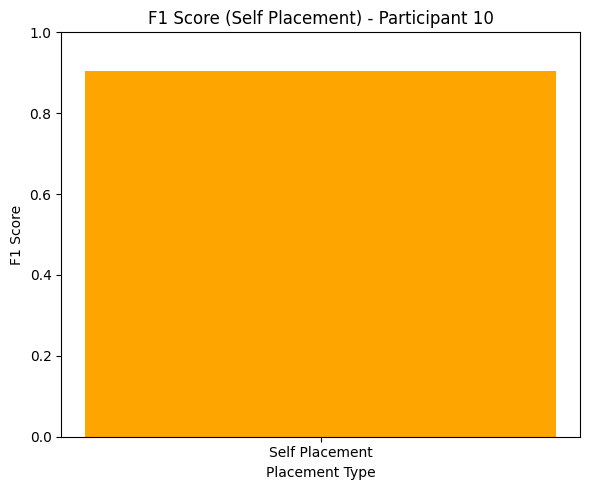

In [ ]:
#@title Participant left out = 10 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='10', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log']
Testing Files (Self): ['subject9_self.log']
Training Data Shapes - Features: (2260206, 3), Labels: (2260206,)
Test Data Shapes - Features: (201704, 3), Labels: (201704,)
Sliding Window Shapes - Training: (15067, 3, 300), Testing: (1343, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 499.9660, Val Loss: 51.6784, Val Accuracy: 0.9253
Participant 9 Self-Placement Accuracy: 0.9345, F1 Score: 0.9297


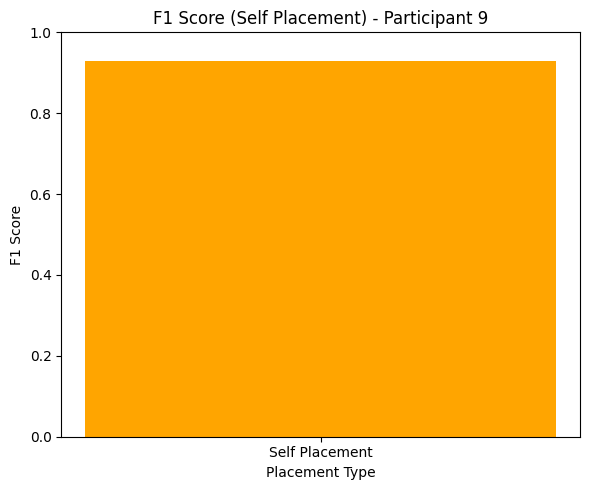

In [ ]:
#@title Participant left out = 9 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='9', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject8_self.log']
Training Data Shapes - Features: (2257789, 3), Labels: (2257789,)
Test Data Shapes - Features: (204121, 3), Labels: (204121,)
Sliding Window Shapes - Training: (15050, 3, 300), Testing: (1359, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 500.2484, Val Loss: 38.5709, Val Accuracy: 0.9392
Participant 8 Self-Placement Accuracy: 0.9220, F1 Score: 0.9136


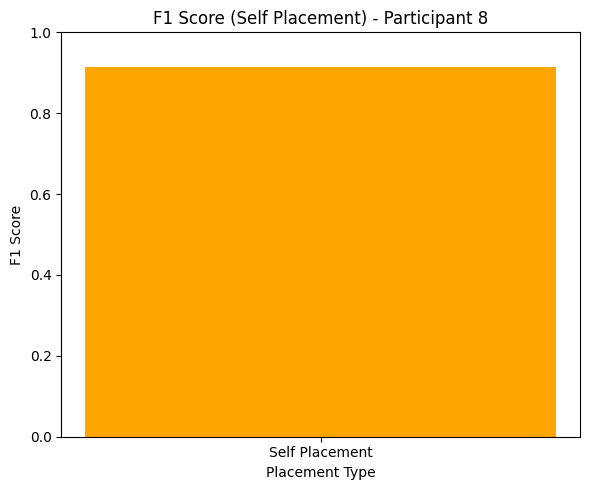

In [ ]:
#@title Participant left out = 8 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='8', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject7_self.log']
Training Data Shapes - Features: (2299217, 3), Labels: (2299217,)
Test Data Shapes - Features: (162693, 3), Labels: (162693,)
Sliding Window Shapes - Training: (15327, 3, 300), Testing: (1083, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 516.3618, Val Loss: 42.1322, Val Accuracy: 0.9344
Participant 7 Self-Placement Accuracy: 0.8994, F1 Score: 0.8788


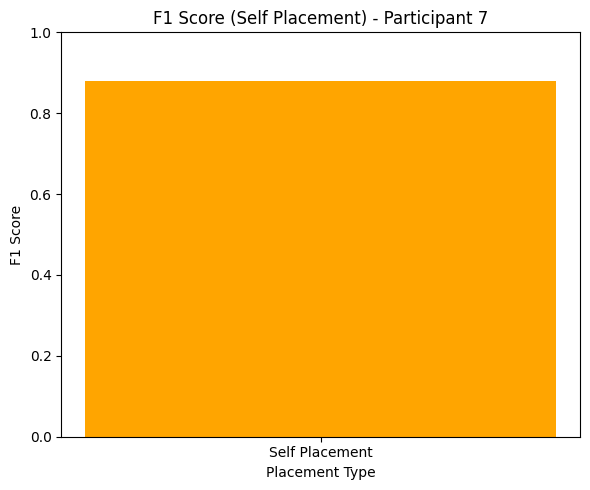

In [ ]:
#@title Participant left out = 7 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='7', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject3_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject4_self.log']
Training Data Shapes - Features: (2261734, 3), Labels: (2261734,)
Test Data Shapes - Features: (200176, 3), Labels: (200176,)
Sliding Window Shapes - Training: (15077, 3, 300), Testing: (1333, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 527.3860, Val Loss: 40.0488, Val Accuracy: 0.9400
Participant 4 Self-Placement Accuracy: 0.8440, F1 Score: 0.8337


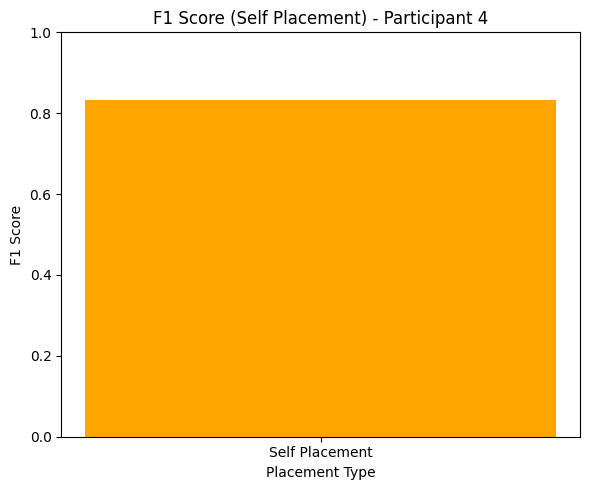

In [ ]:
#@title Participant left out = 4 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='4', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject11_self.log', 'subject7_self.log', 'subject15_self.log', 'subject4_self.log', 'subject17_self.log', 'subject16_self.log', 'subject2_self.log', 'subject8_self.log', 'subject10_self.log', 'subject12_self.log', 'subject1_self.log', 'subject14_self.log', 'subject9_self.log']
Testing Files (Self): ['subject3_self.log']
Training Data Shapes - Features: (2295743, 3), Labels: (2295743,)
Test Data Shapes - Features: (166167, 3), Labels: (166167,)
Sliding Window Shapes - Training: (15303, 3, 300), Testing: (1106, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 493.7376, Val Loss: 39.4536, Val Accuracy: 0.9369
Participant 3 Self-Placement Accuracy: 0.8816, F1 Score: 0.8793


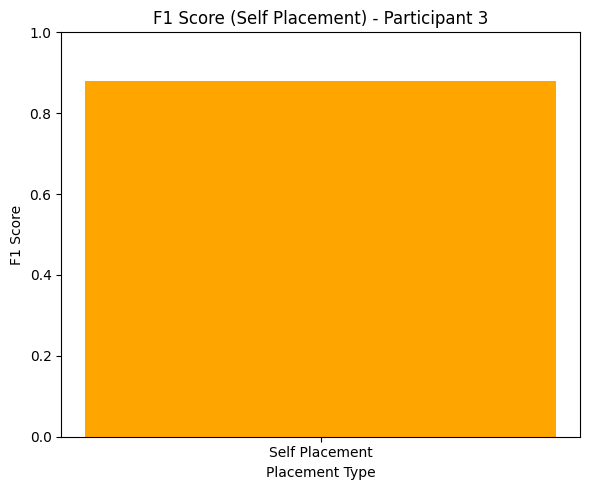

In [ ]:
#@title Participant left out = 3 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='3', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject12_self.log', 'subject4_self.log', 'subject17_self.log', 'subject15_self.log', 'subject1_self.log', 'subject7_self.log', 'subject10_self.log', 'subject14_self.log', 'subject9_self.log', 'subject11_self.log', 'subject16_self.log', 'subject8_self.log', 'subject3_self.log']
Testing Files (Self): ['subject2_self.log']
Training Data Shapes - Features: (2296678, 3), Labels: (2296678,)
Test Data Shapes - Features: (165232, 3), Labels: (165232,)
Sliding Window Shapes - Training: (15310, 3, 300), Testing: (1100, 3, 300)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct mal

131 Weights loaded
Epoch 1/1, Loss: 498.7888, Val Loss: 45.4370, Val Accuracy: 0.9295
Participant 2 Self-Placement Accuracy: 0.9127, F1 Score: 0.9068


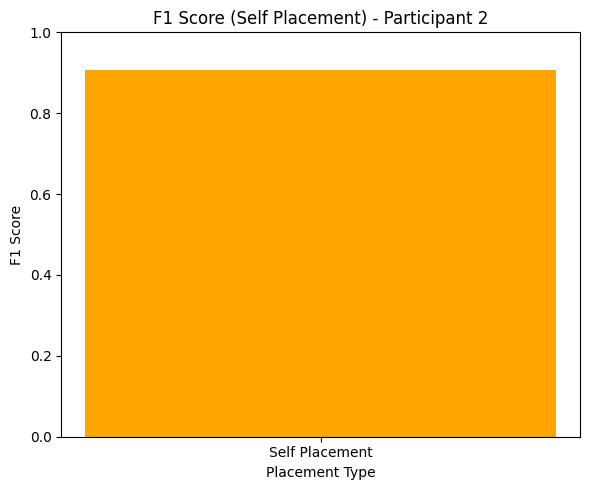

In [ ]:
#@title Participant left out = 2 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='2', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)


Training Files (Self): ['subject12_self.log', 'subject4_self.log', 'subject17_self.log', 'subject15_self.log', 'subject7_self.log', 'subject10_self.log', 'subject14_self.log', 'subject9_self.log', 'subject2_self.log', 'subject11_self.log', 'subject16_self.log', 'subject8_self.log', 'subject3_self.log']
Testing Files (Self): ['subject1_self.log']
Training Data Shapes - Features: (2295705, 3), Labels: (2295705,)
Test Data Shapes - Features: (166205, 3), Labels: (166205,)
Sliding Window Shapes - Training: (15303, 3, 300), Testing: (1107, 3, 300)


Using cache found in /root/.cache/torch/hub/OxWearables_ssl-wearables_main
/root/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

131 Weights loaded
Epoch 1/1, Loss: 513.2127, Val Loss: 54.7210, Val Accuracy: 0.9154
Participant 1 Self-Placement Accuracy: 0.8979, F1 Score: 0.8833


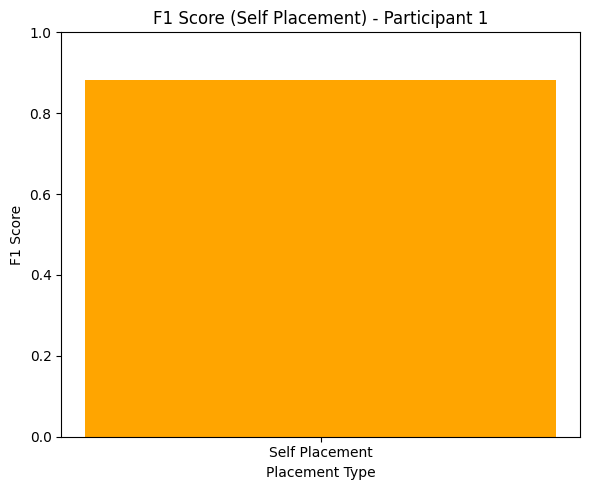

In [ ]:
#@title Participant left out = 1 (Self only)
model, accuracy, f1 = train_and_evaluate_self(participant_id='1', dataset_path=dataset_path, anomaly_files=anomaly_files, num_epochs=1)
